In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True


Running as a Colab notebook
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4

In [2]:
# external libraries
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import AutoModelForCausalLM, AutoTokenizer

import tqdm.auto as tqdm
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import numpy as np

# custom libraries
from src.dataset_handling import TextClassificationDataset
from src.utils import get_hidden_activations_multiple_hookpoints, activation_label_generator
from src.sparse_probes import ClassificationProbe

In [3]:
model_url = "EleutherAI/pythia-70m"
hookpoint_name = 'gpt_neox.layers.$.mlp.act'

model = AutoModelForCausalLM.from_pretrained(model_url).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_url)
batch_size = 32

num_hookpoints = model.config.num_hidden_layers
hookpoints = [hookpoint_name.replace('$', str(i)) for i in range(num_hookpoints)]
input_size = model.config.intermediate_size

data_path = 'data/split/tedtalks_train.tsv'
data = TextClassificationDataset.from_tsv(data_path)

dataloader = DataLoader(
    dataset=data,
    batch_size=batch_size,
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [4]:
class ProbeTrainer():
    def __init__(self, input_size, learning_rate, reg_lambda, hookpoint, device):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        self.hookpoint = hookpoint
        self.name = f'{self.hookpoint}.lambda{self.reg_lambda}'

        self.model = ClassificationProbe(in_dim=self.input_size, device=device).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.BCELoss()

        self.batches = 0

        self.losses = []

    def train_step(self, input_, labels):
        outputs = self.model(input_)
        loss = self.loss_fn(outputs, labels)
        pre_reg_loss = loss.item()
        loss += self.reg_lambda * sum(torch.norm(param, 2) for param in self.model.parameters())
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.losses.append((loss.item(), pre_reg_loss))
        self.batches += 1
        return loss

    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        losses, pre_reg_losses = zip(*self.losses)
        ax.plot(losses, label='Loss')
        ax.plot(pre_reg_losses, label='Pre-regularization loss')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax.set_title(self.name)
        fig.legend()

        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()

In [5]:

learning_rate=1e-3
reg_lambdas = np.logspace(np.log10(0.1), np.log10(30), 10)

probe_trainers = [
    ProbeTrainer(input_size, learning_rate, reg_lambda, hookpoint, device)
    for reg_lambda in reg_lambdas
        for hookpoint in hookpoints
]

for activations, labels in activation_label_generator(dataloader, model, hookpoints, tokenizer, device):
    for probe_trainer in probe_trainers:
        loss = probe_trainer.train_step(activations[probe_trainer.hookpoint], labels)
        print(f'{loss}\t', end='')
    print('')


  0%|          | 0/2070 [00:00<?, ?it/s]

0.7503284811973572	0.7563043832778931	0.8055191040039062	0.6989606022834778	0.6441100239753723	0.702195942401886	0.805239737033844	0.7876630425453186	0.8334774374961853	0.7881125211715698	0.7752780318260193	0.7259591817855835	0.9062686562538147	0.8876665830612183	1.0286864042282104	0.8853394985198975	1.01068913936615	0.875489354133606	1.0887926816940308	1.1027092933654785	1.1083704233169556	1.0446659326553345	1.1292167901992798	1.0375055074691772	1.4144315719604492	1.4414050579071045	1.5125688314437866	1.4266562461853027	1.456674337387085	1.3595197200775146	2.074409246444702	2.0889647006988525	2.166419267654419	2.119163990020752	2.228360176086426	1.9454419612884521	3.3991916179656982	3.359956741333008	3.3783116340637207	3.2926759719848633	3.300076961517334	3.3443973064422607	5.60770845413208	5.575314521789551	5.572490215301514	5.758154392242432	5.624824523925781	5.72490930557251	10.364561080932617	9.973960876464844	10.121926307678223	10.076447486877441	9.944229125976562	9.7983589172363

KeyboardInterrupt: 

<ipython-input-4-d5ac22491a2a>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(12, 8))


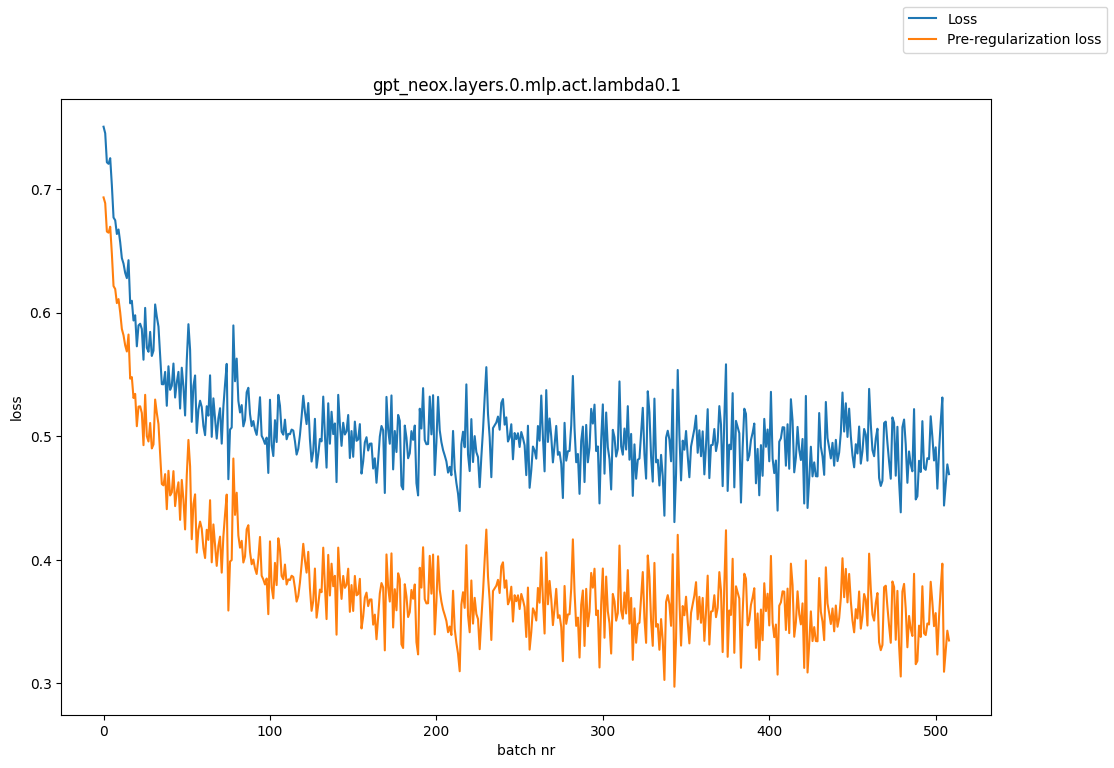

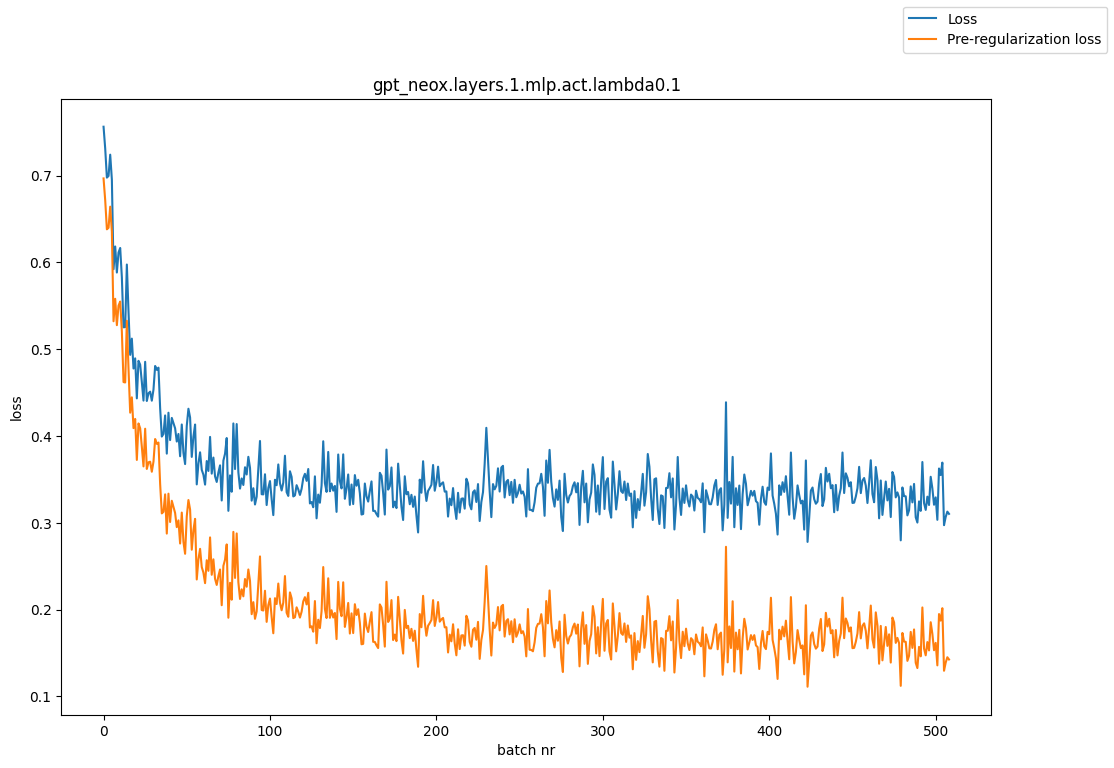

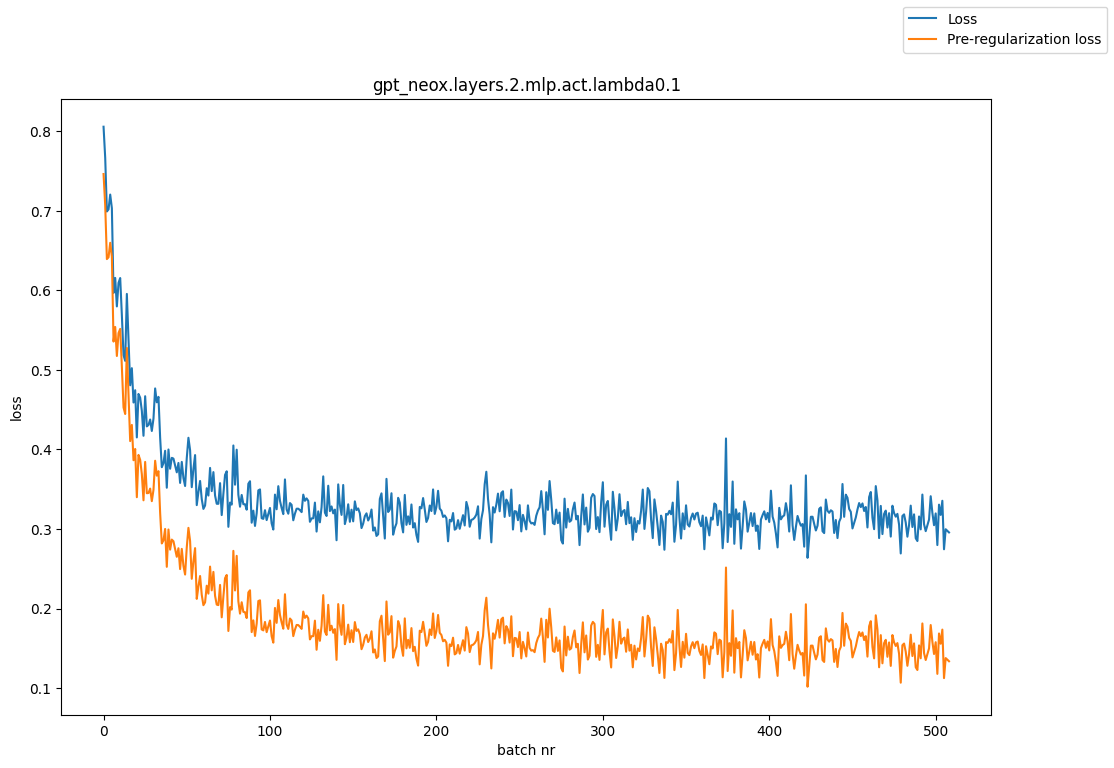

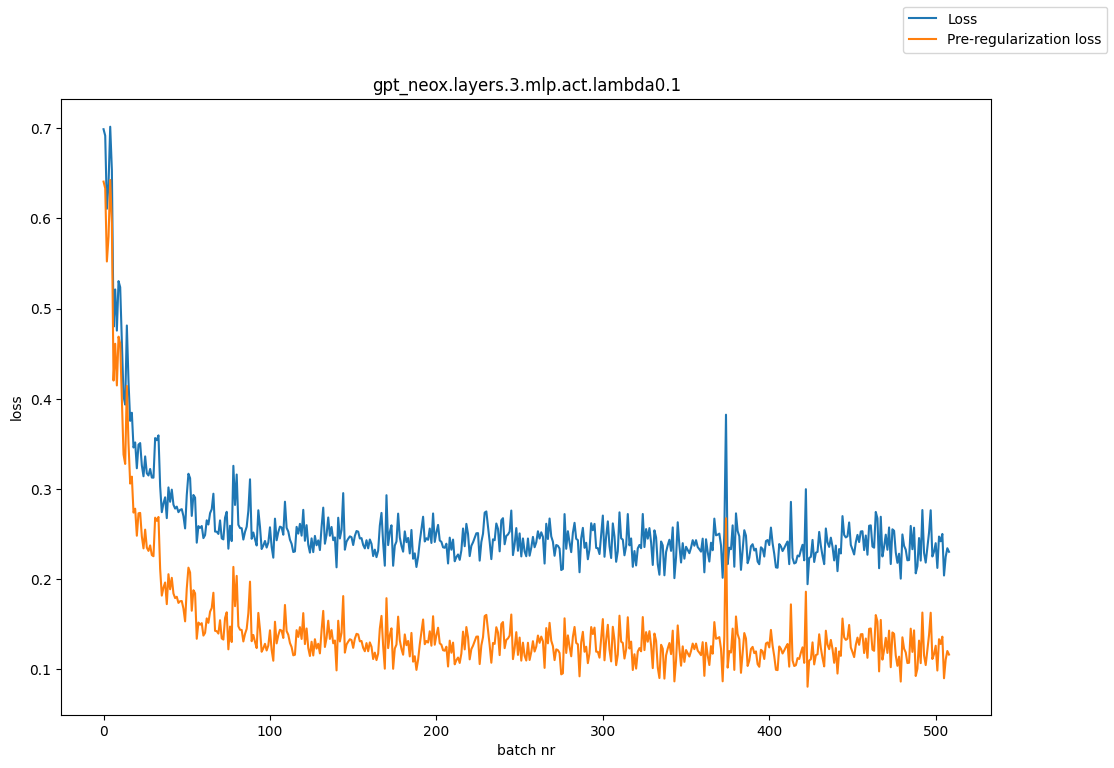

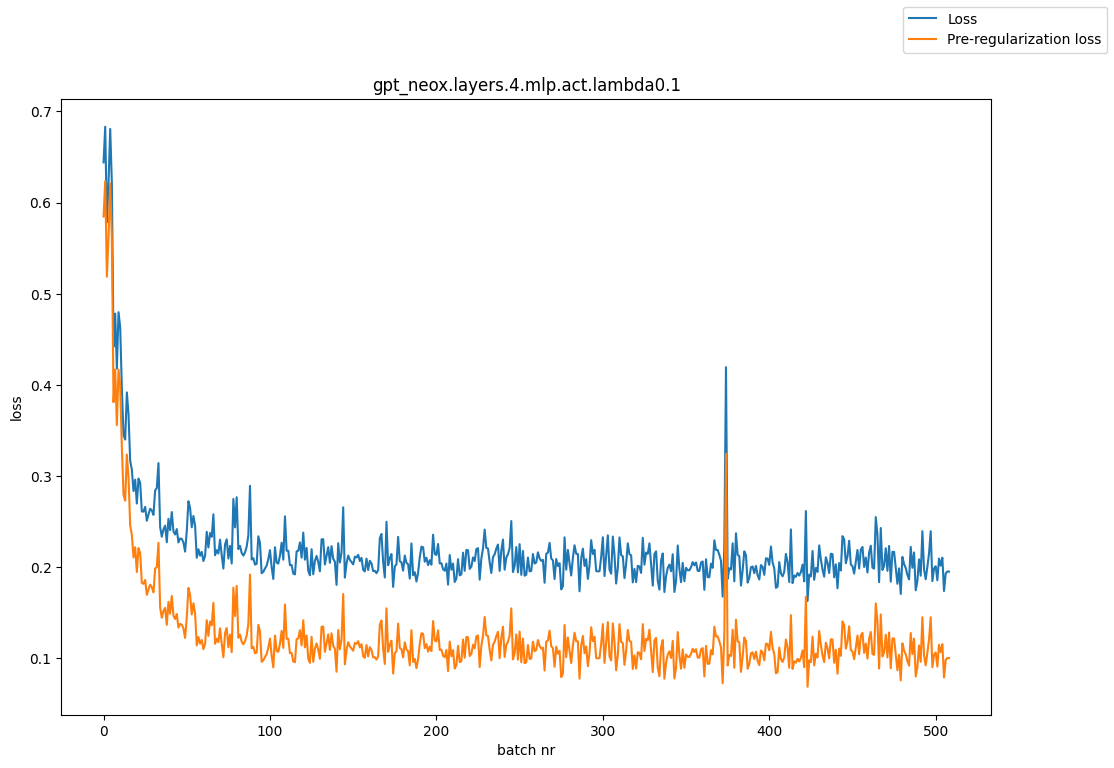

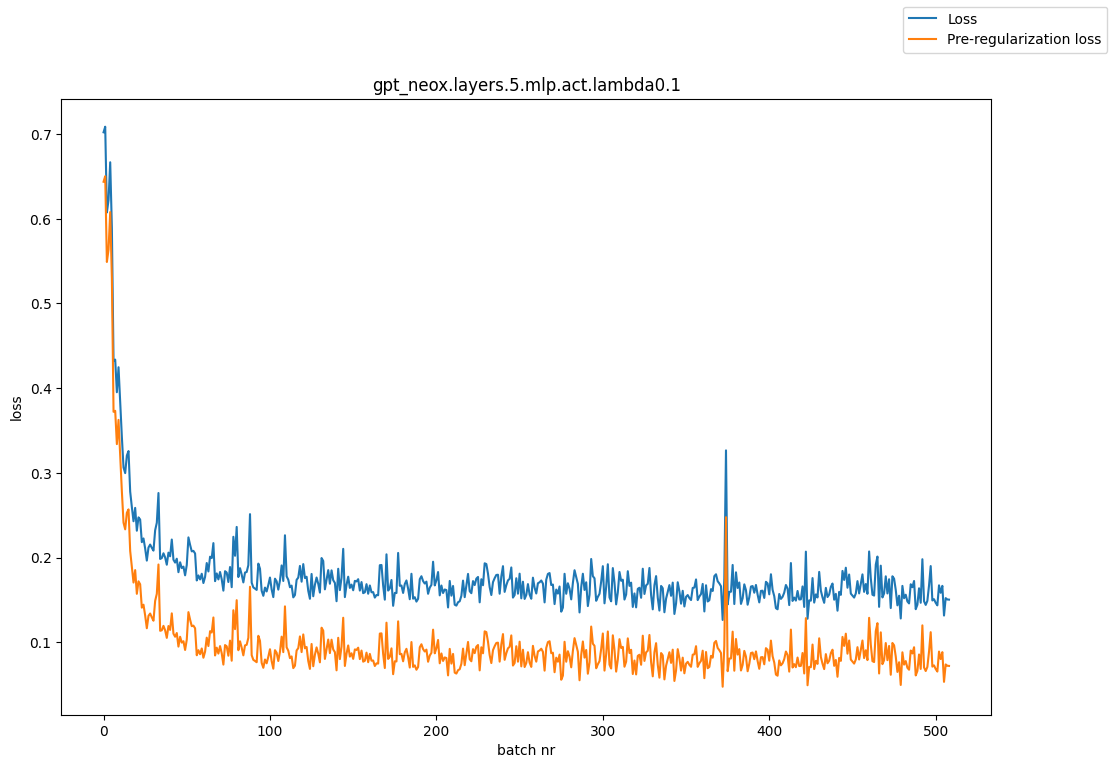

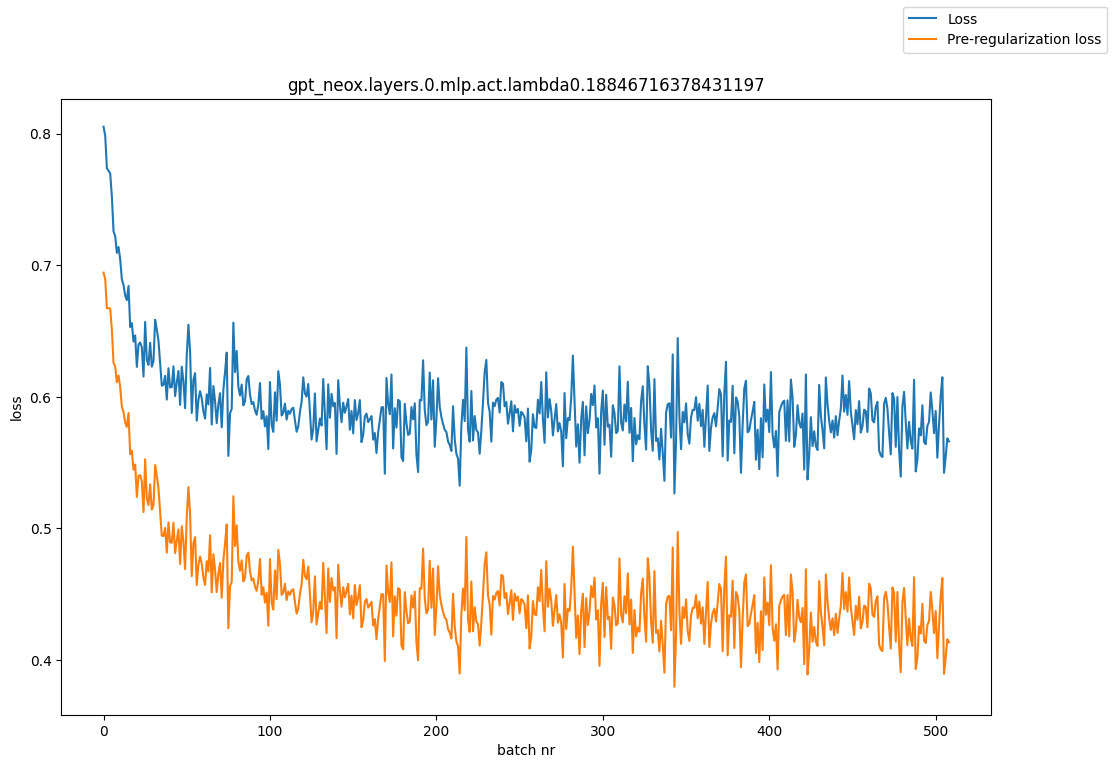

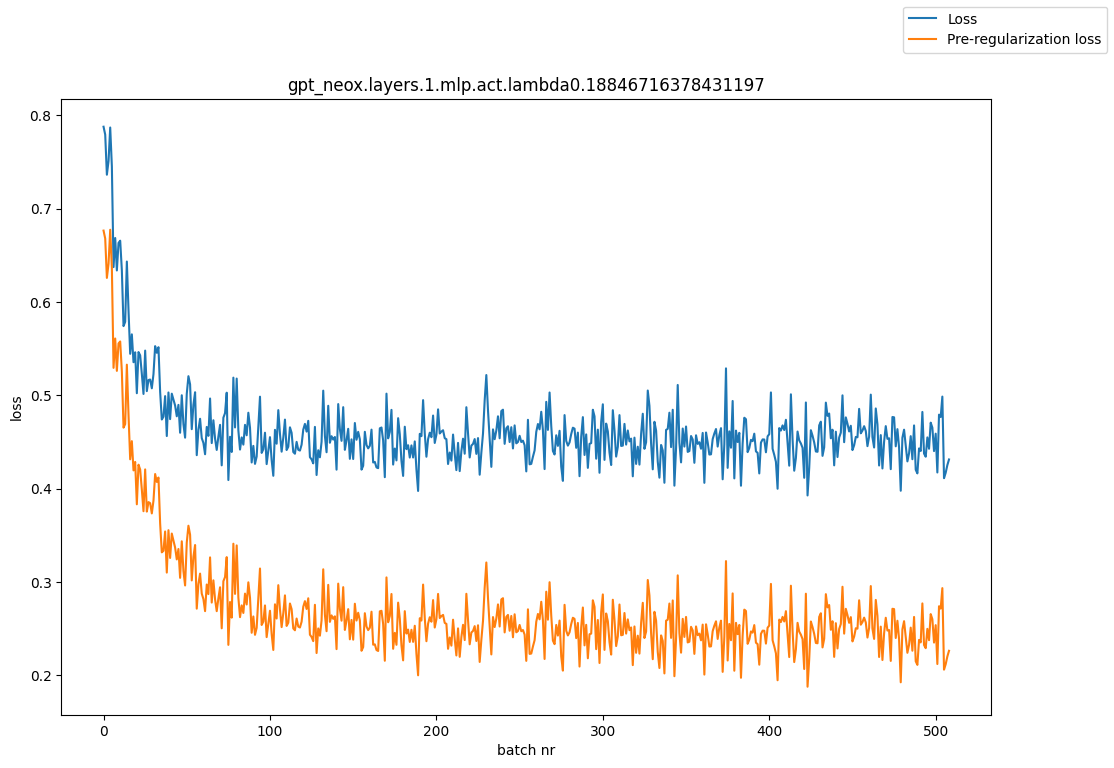

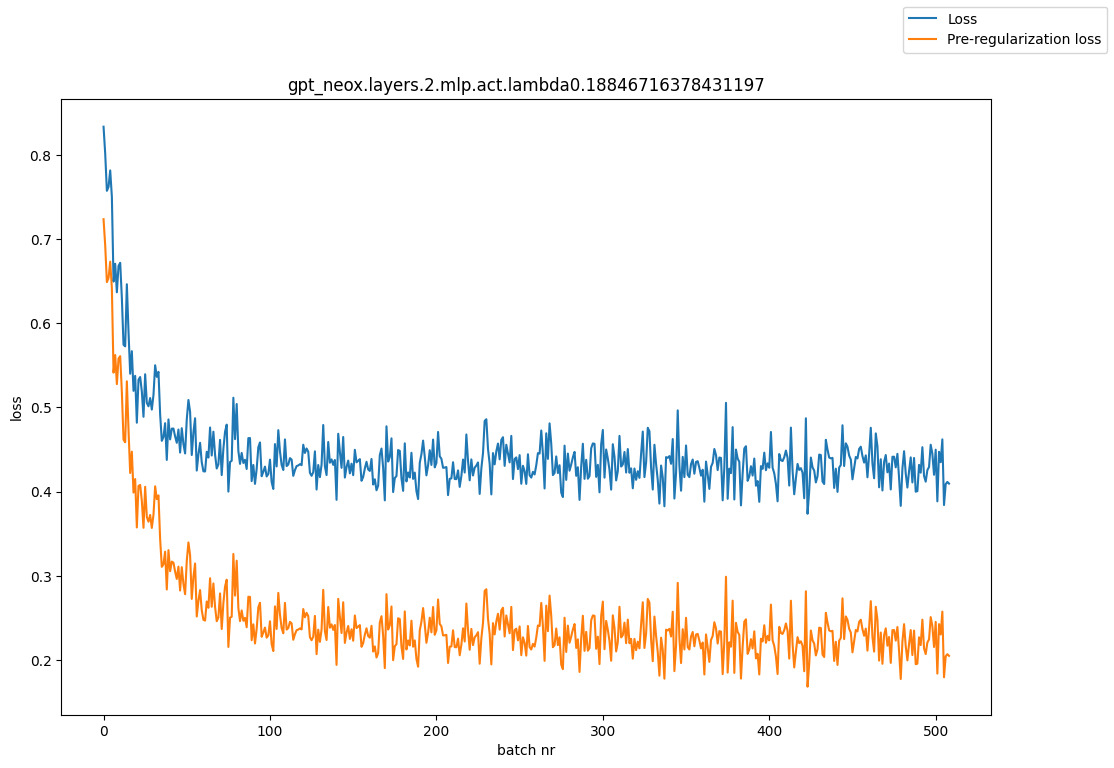

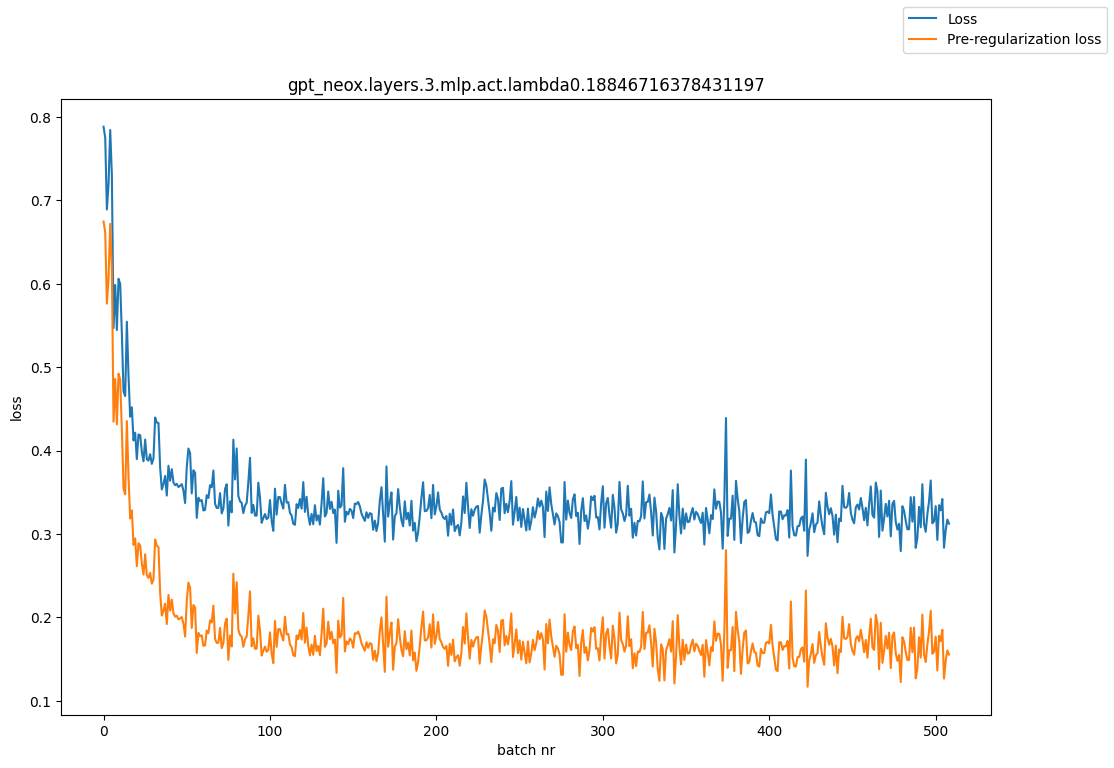

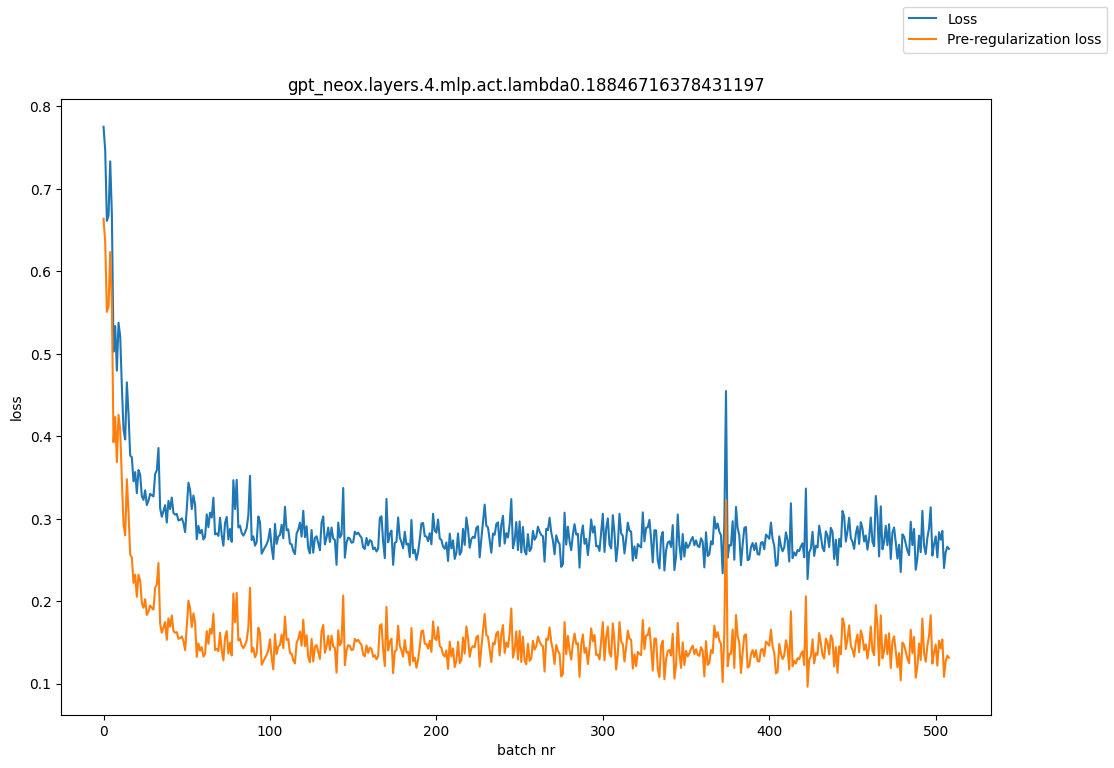

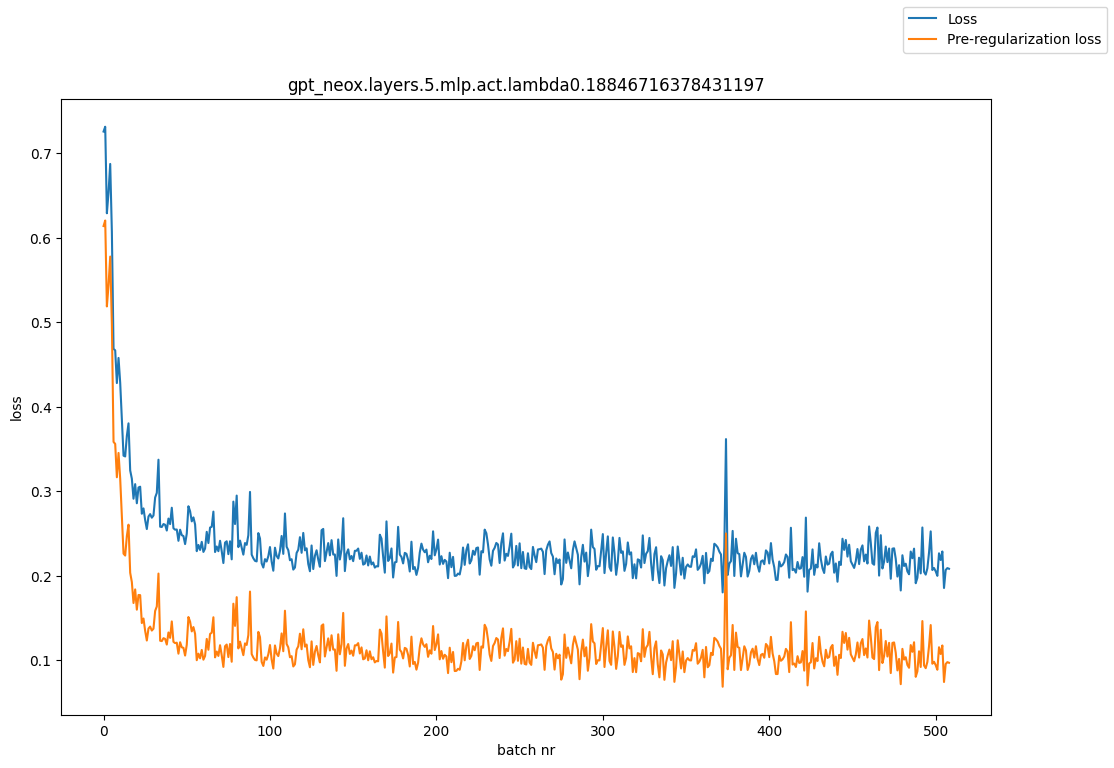

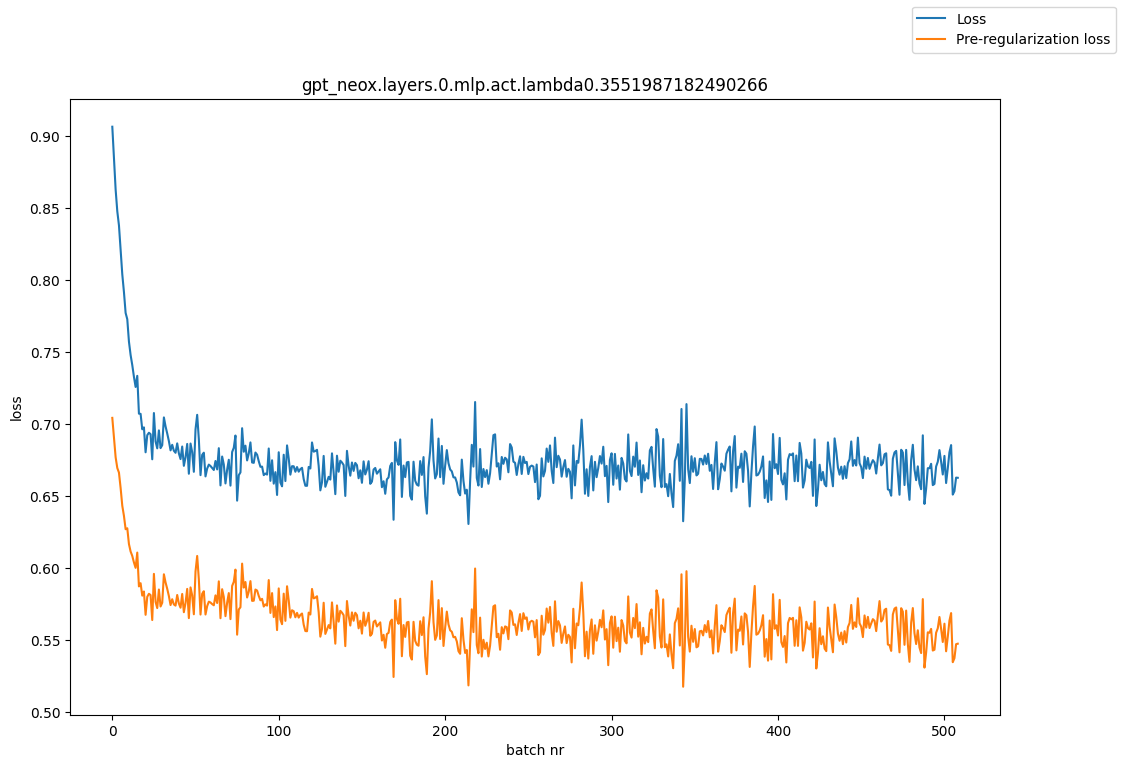

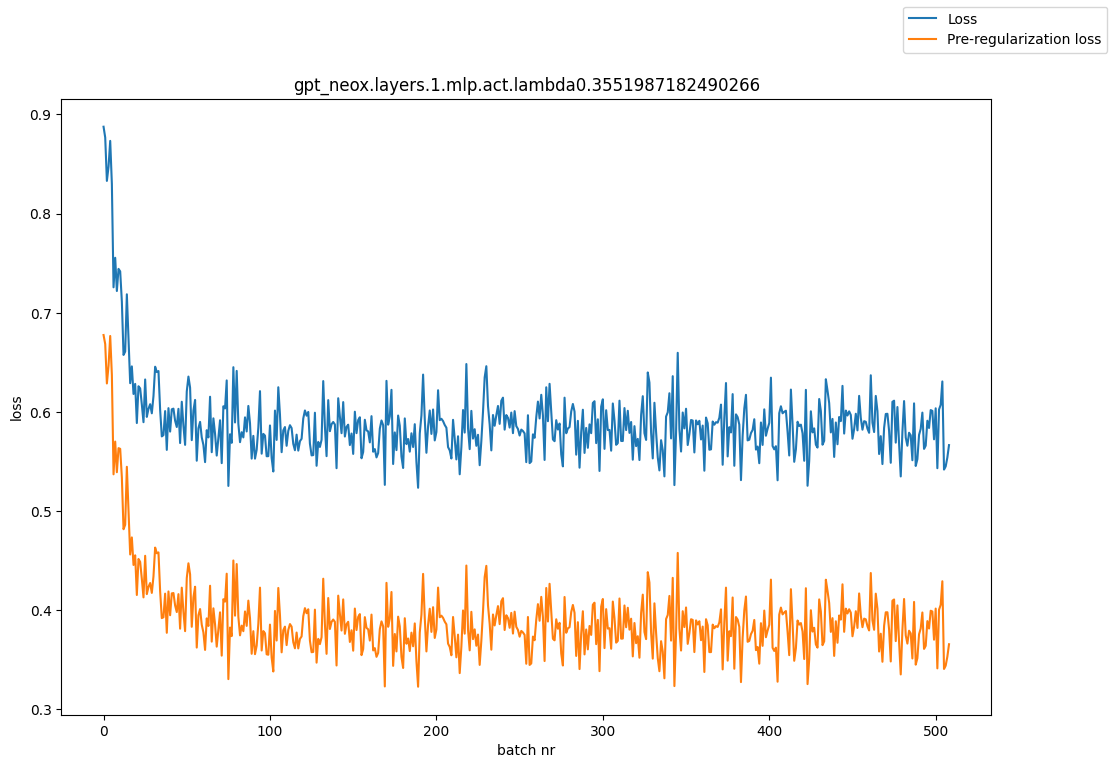

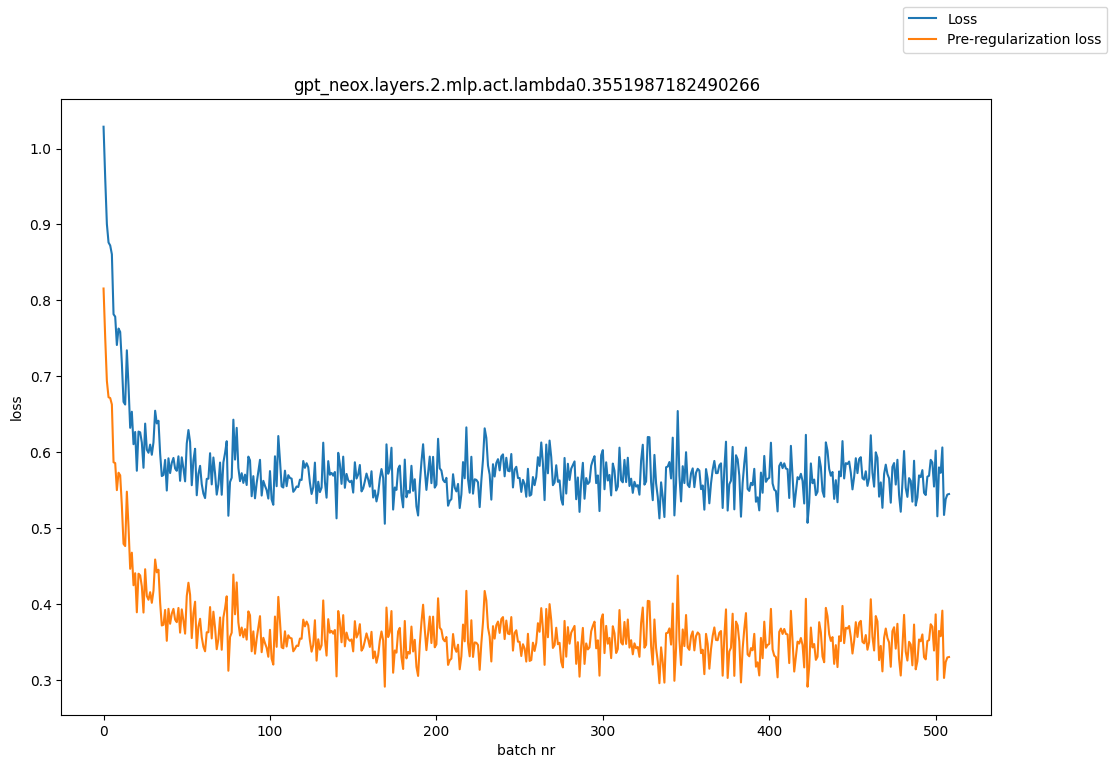

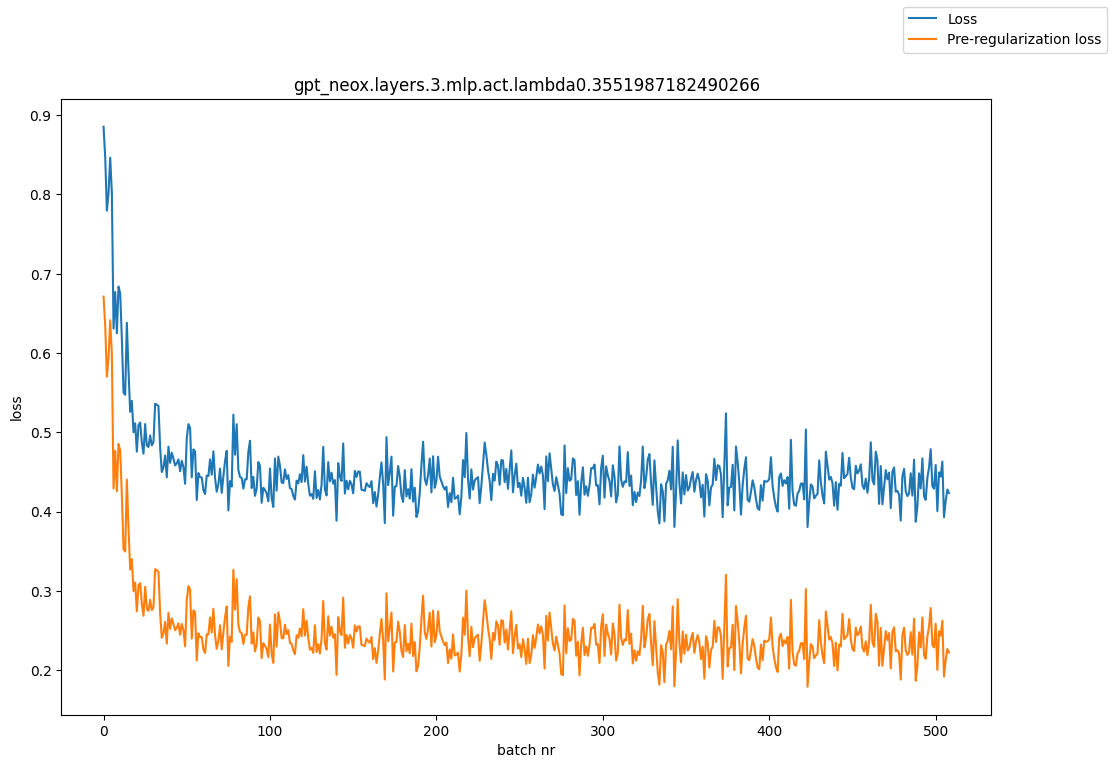

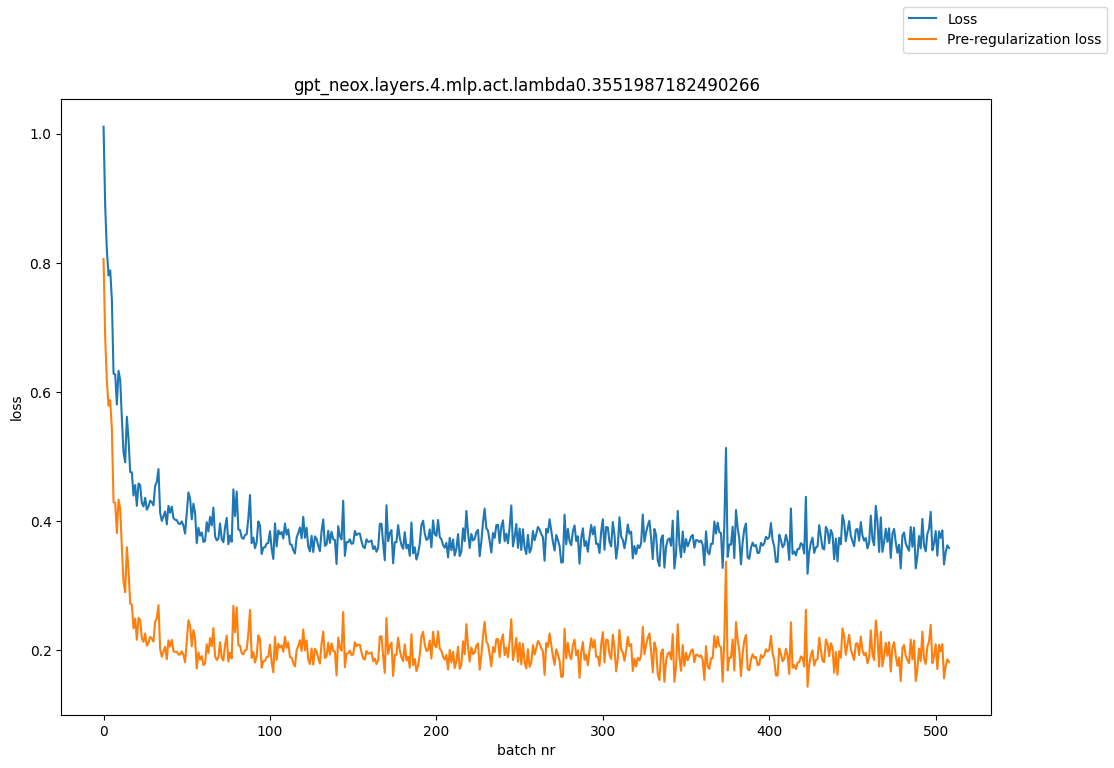

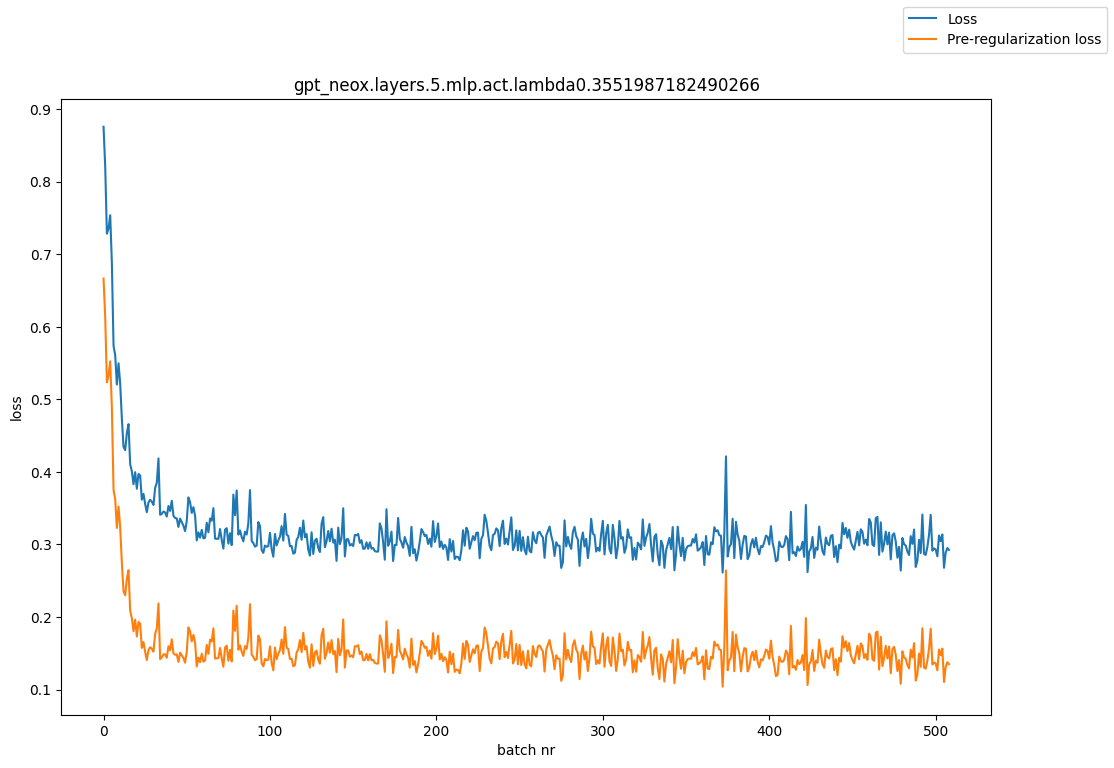

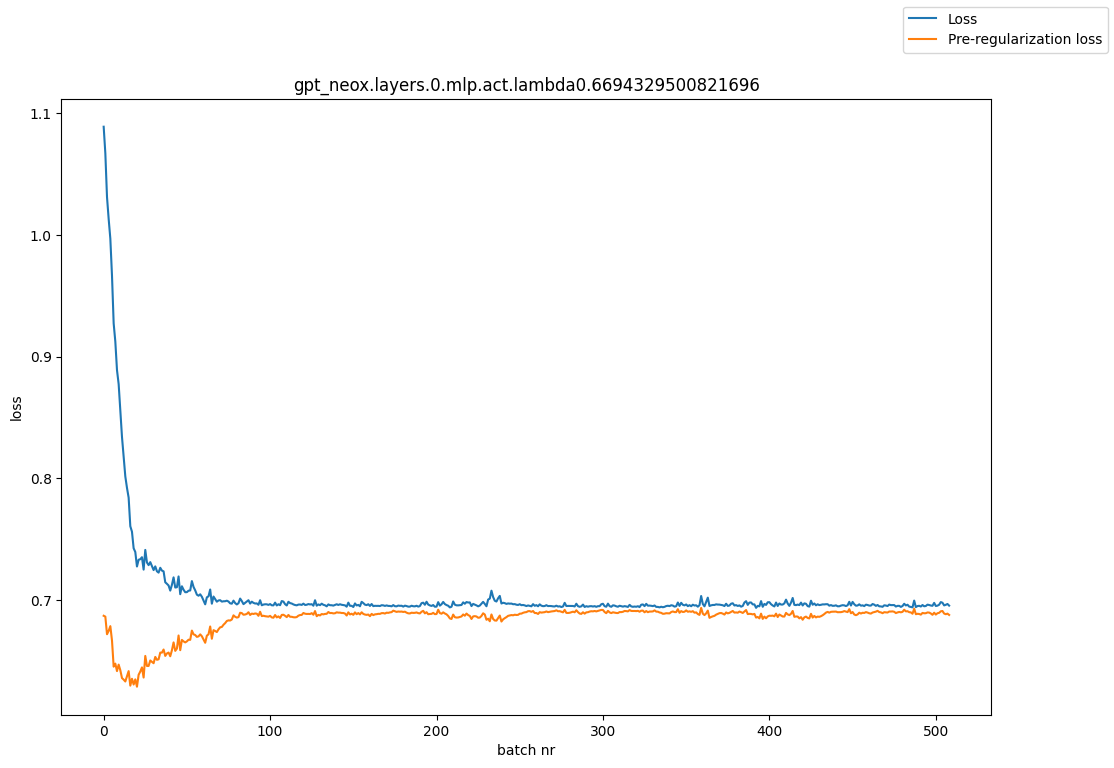

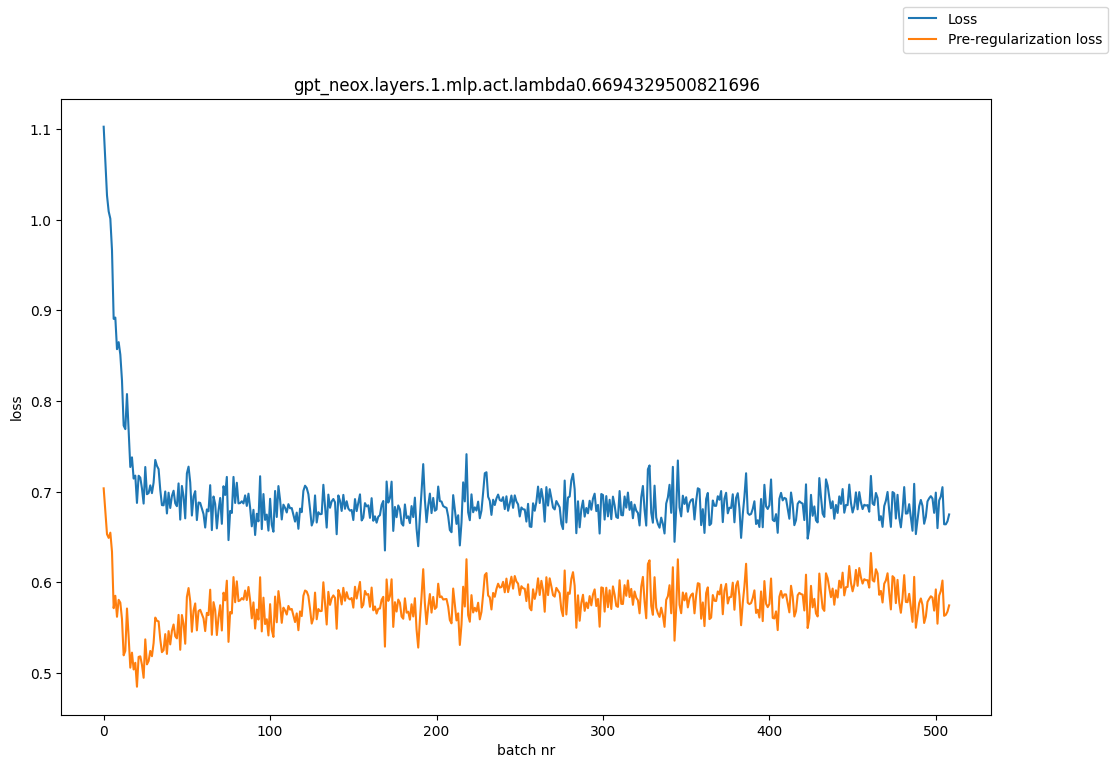

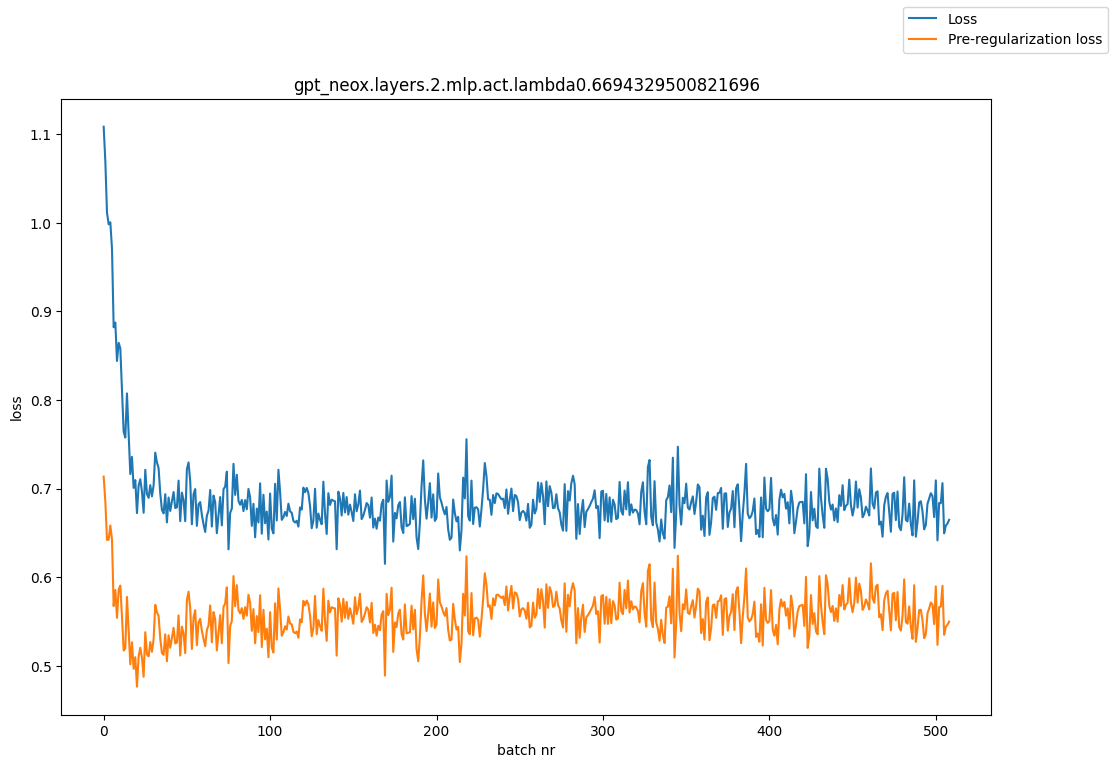

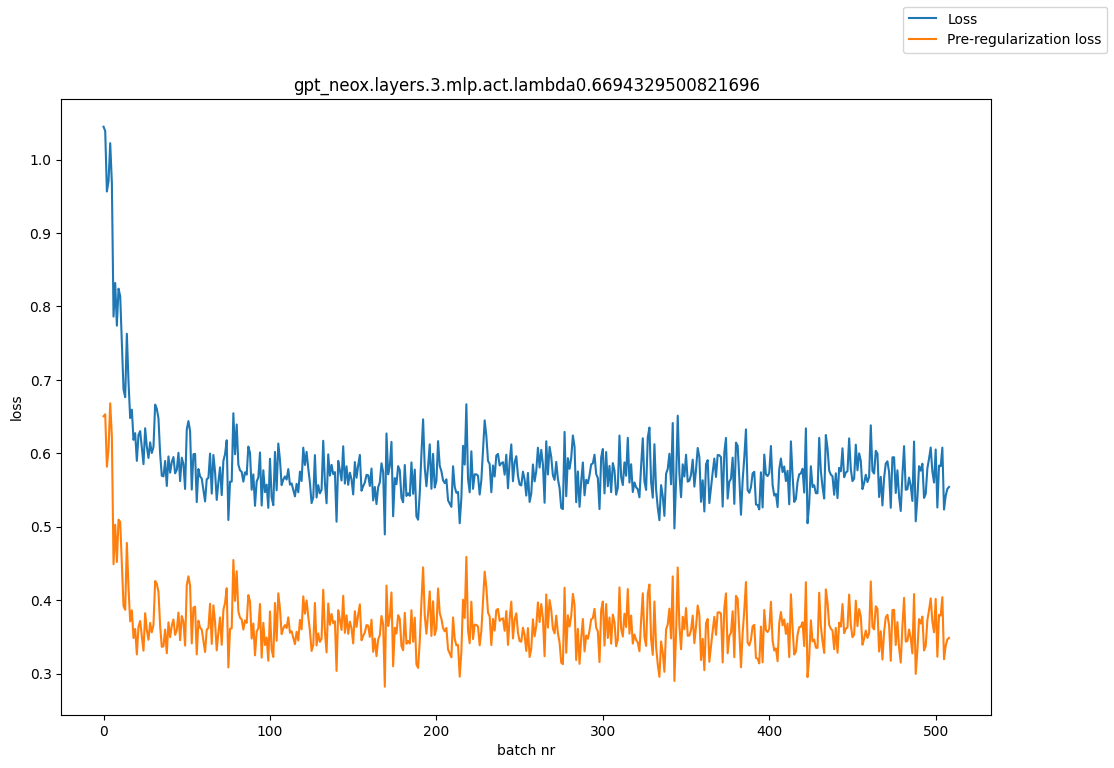

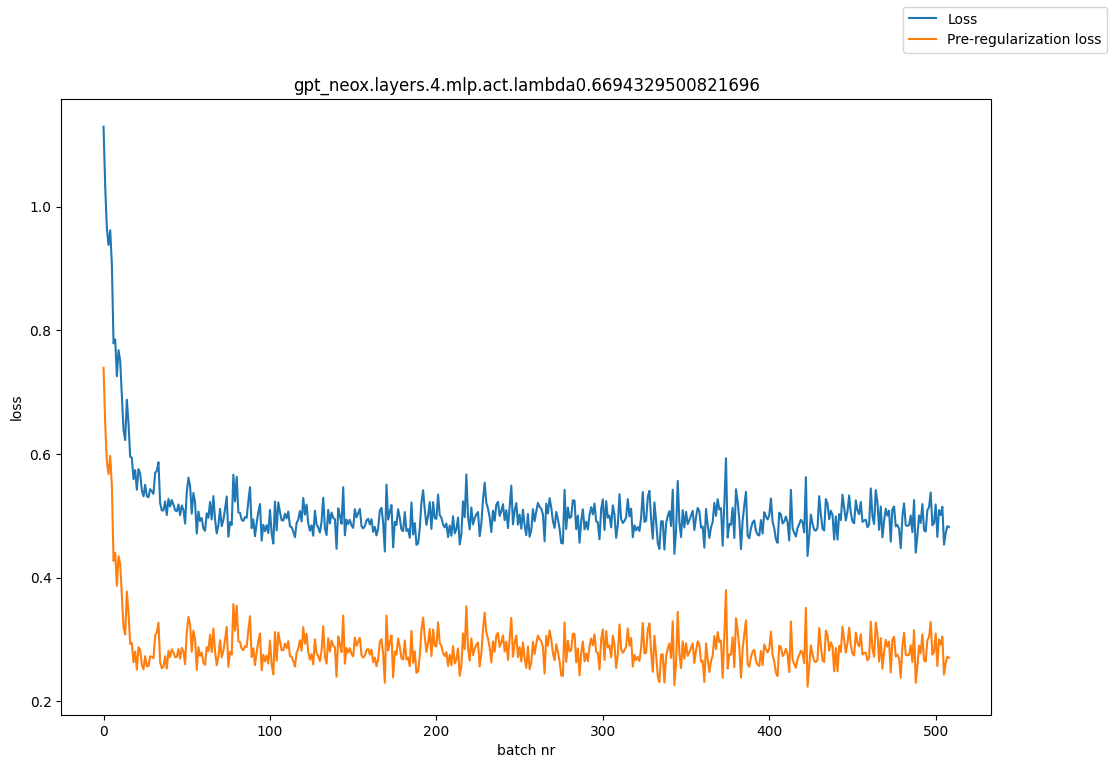

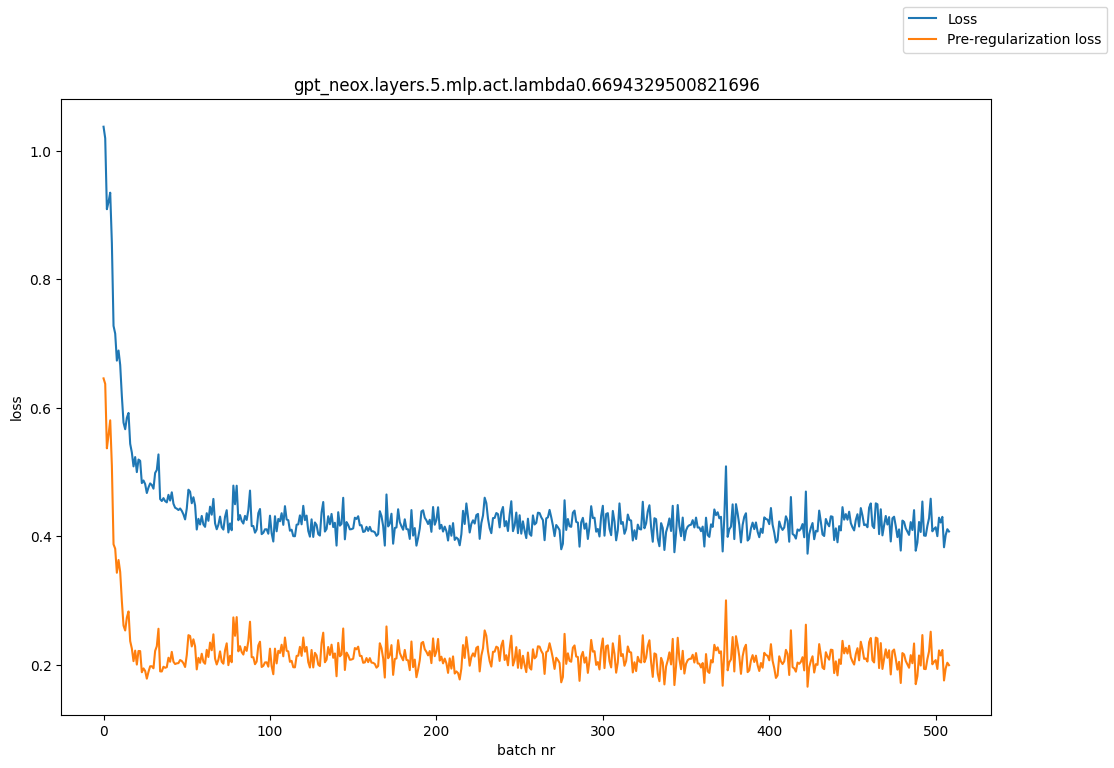

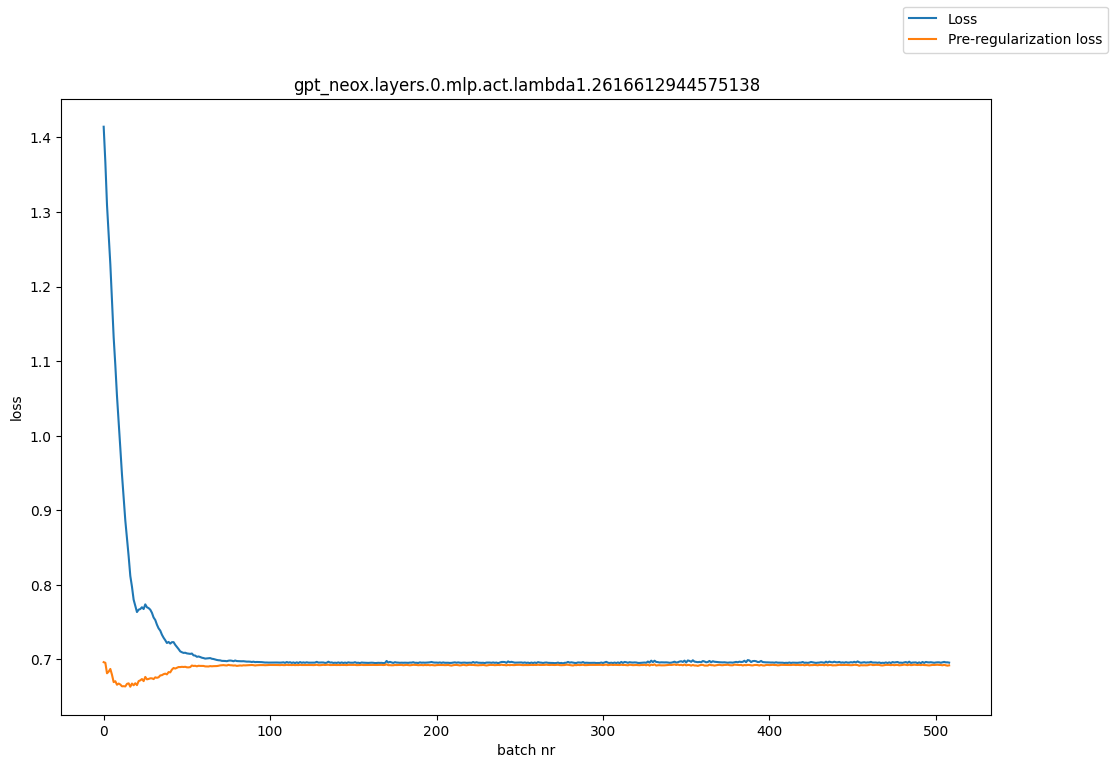

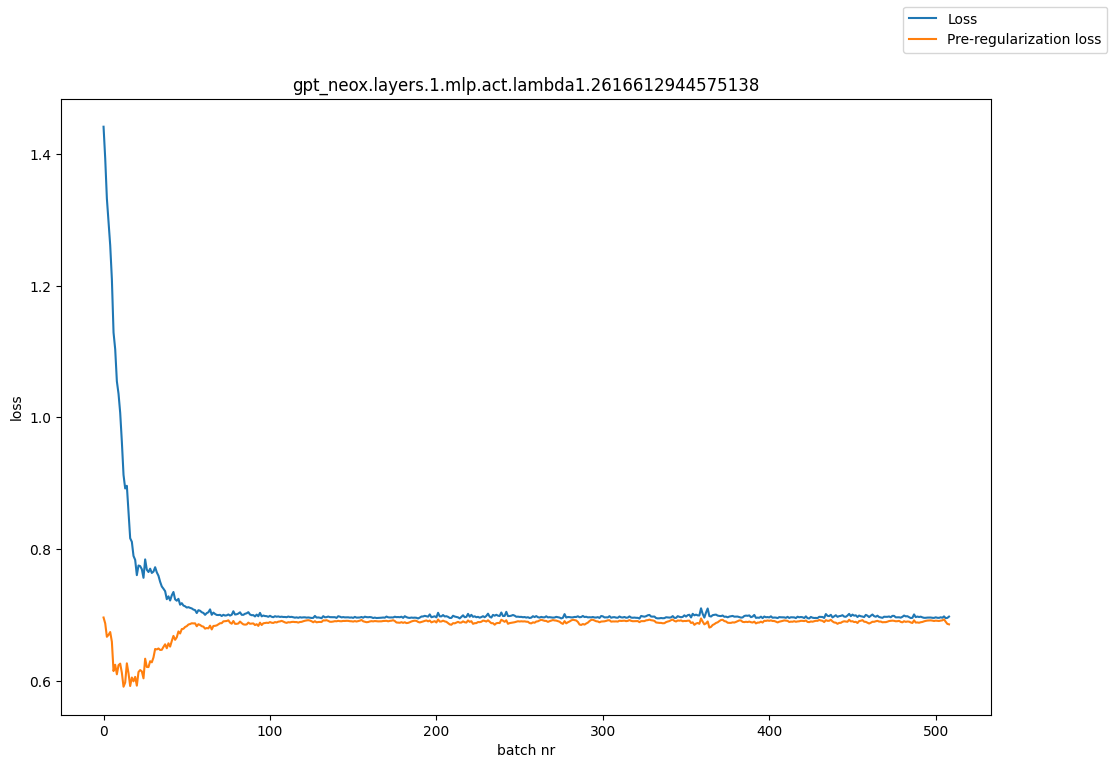

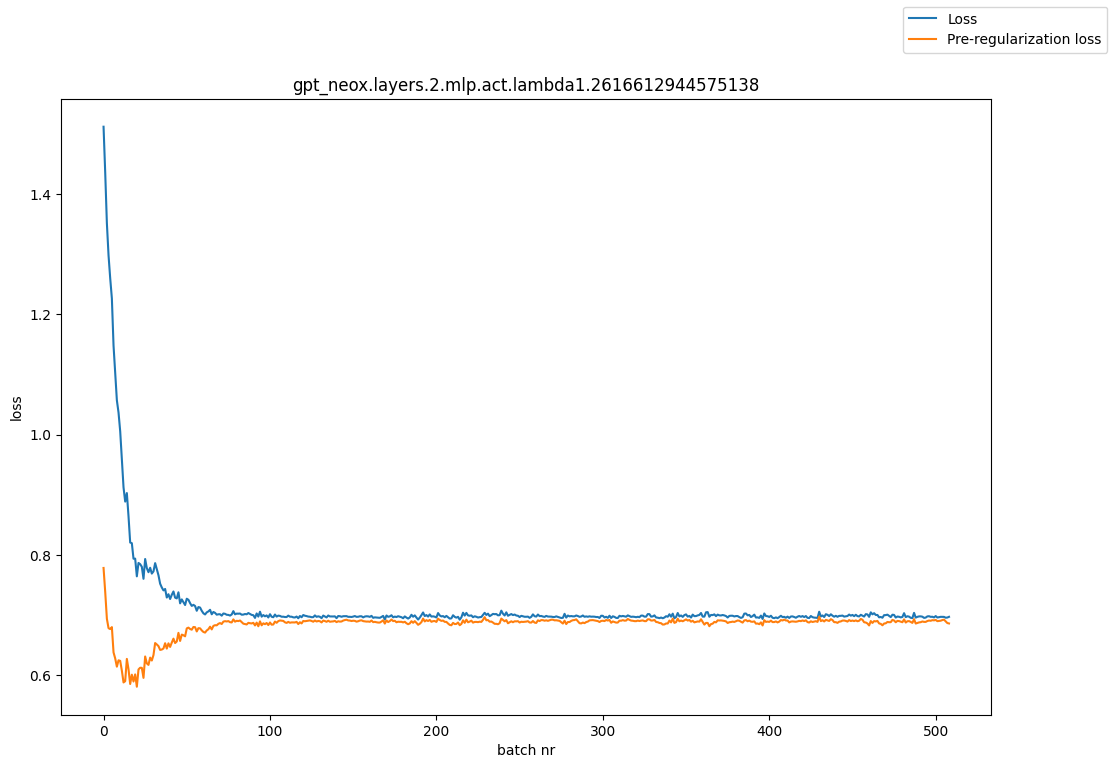

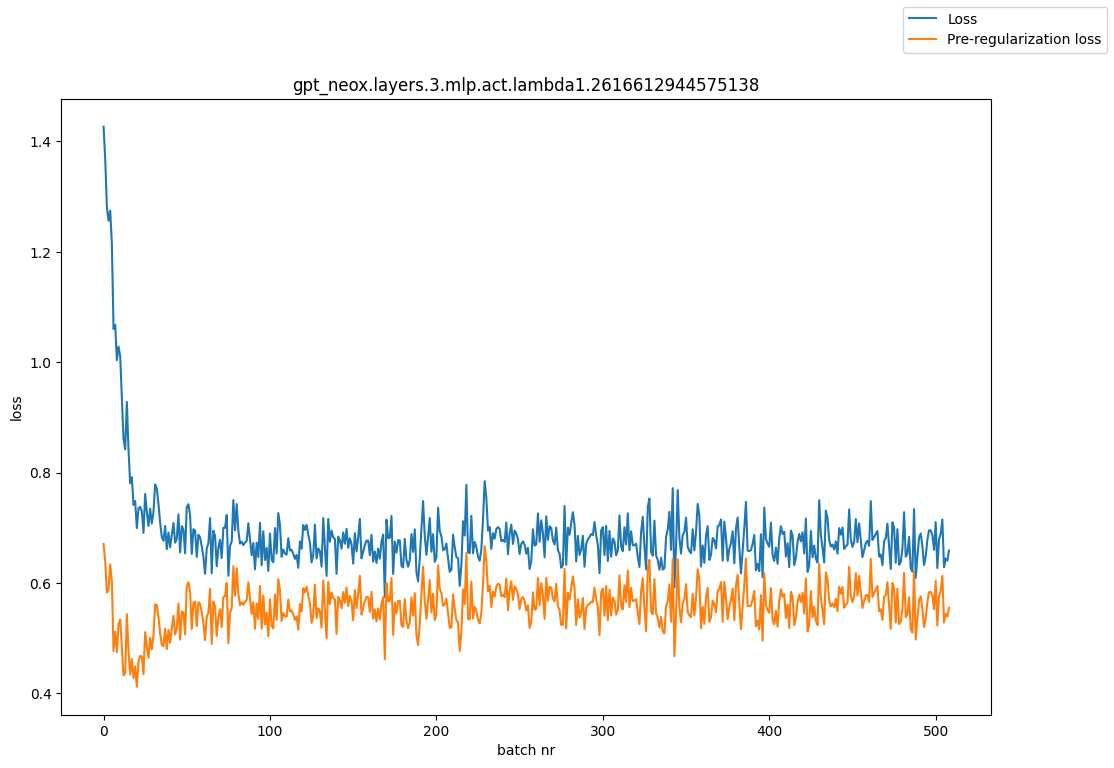

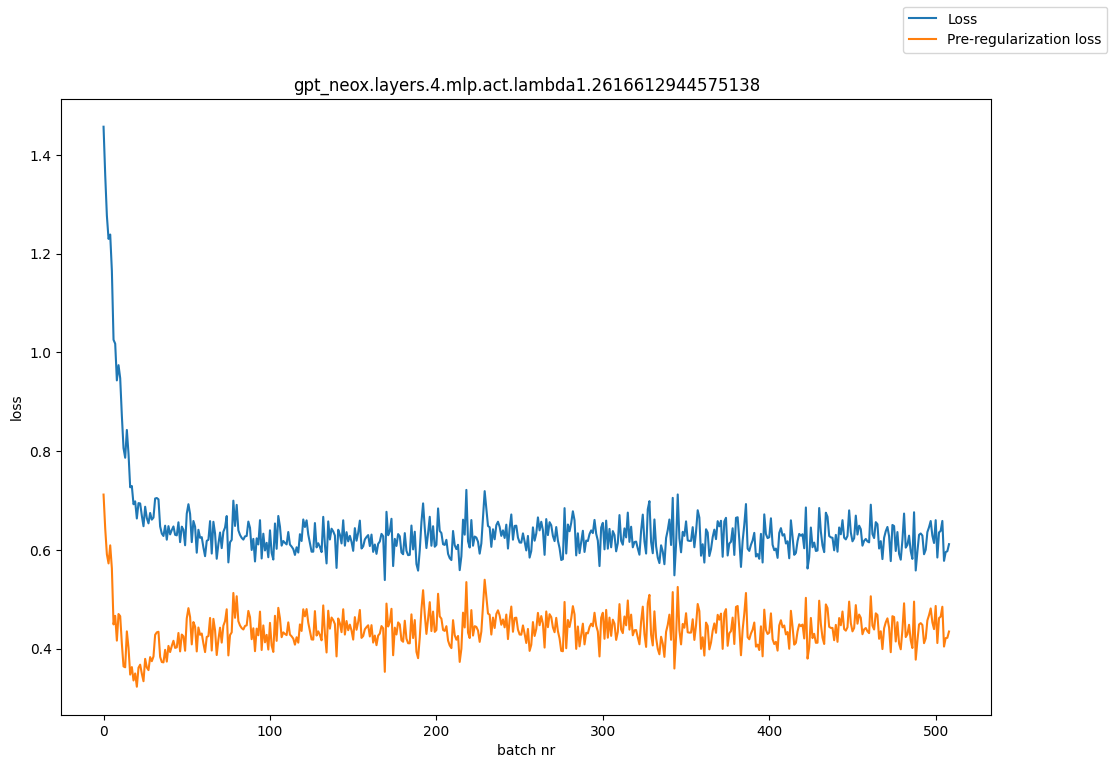

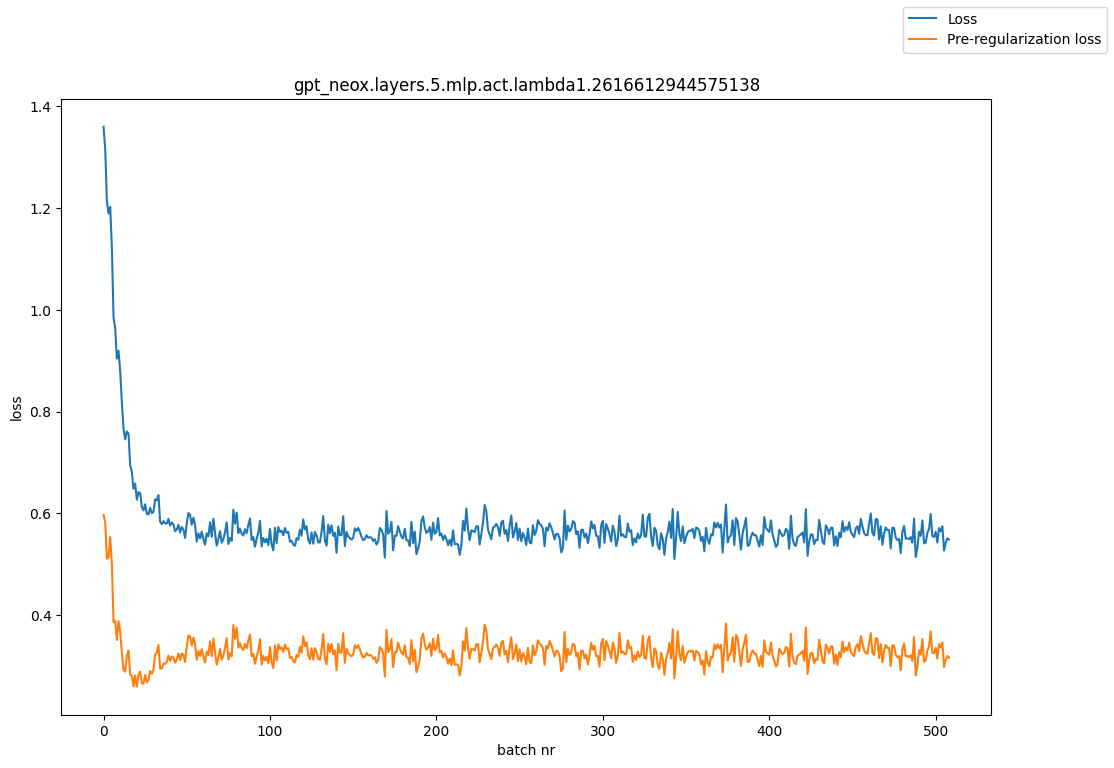

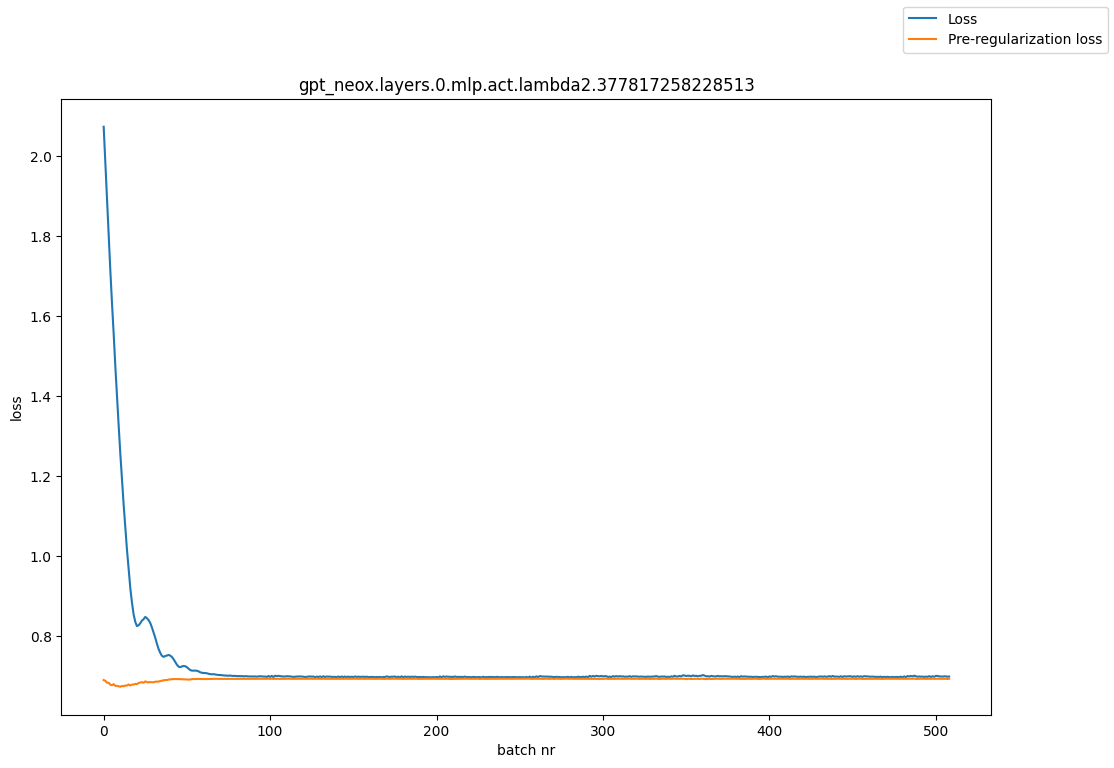

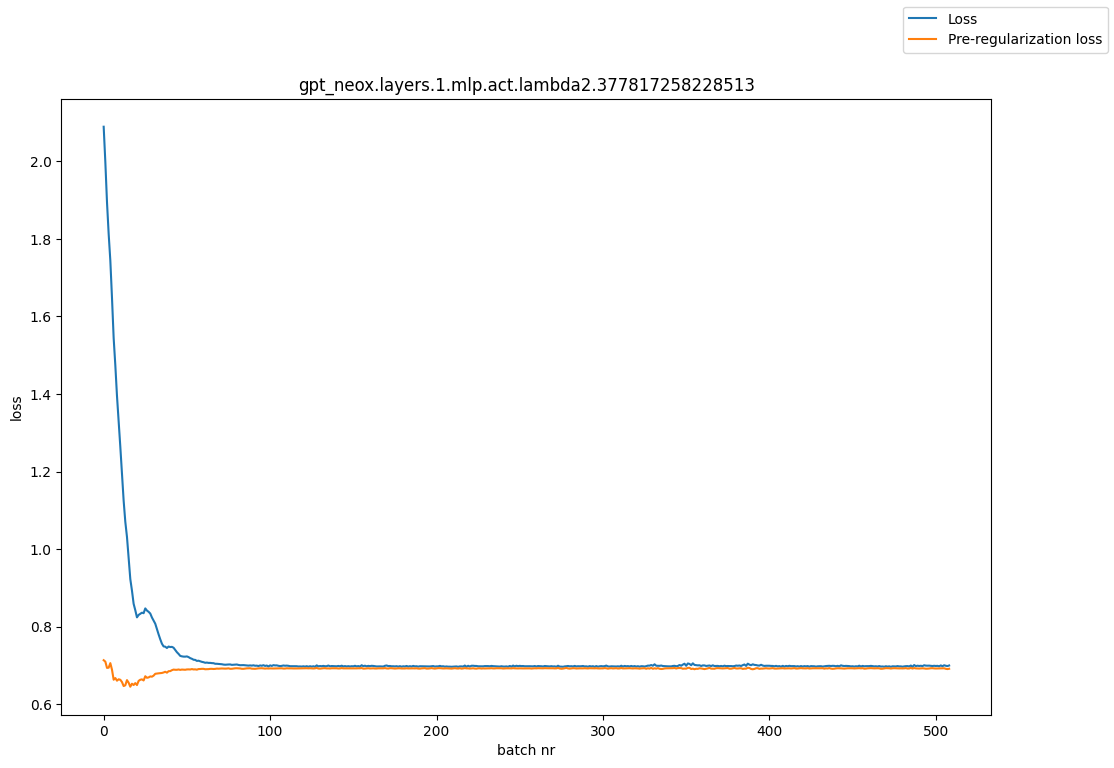

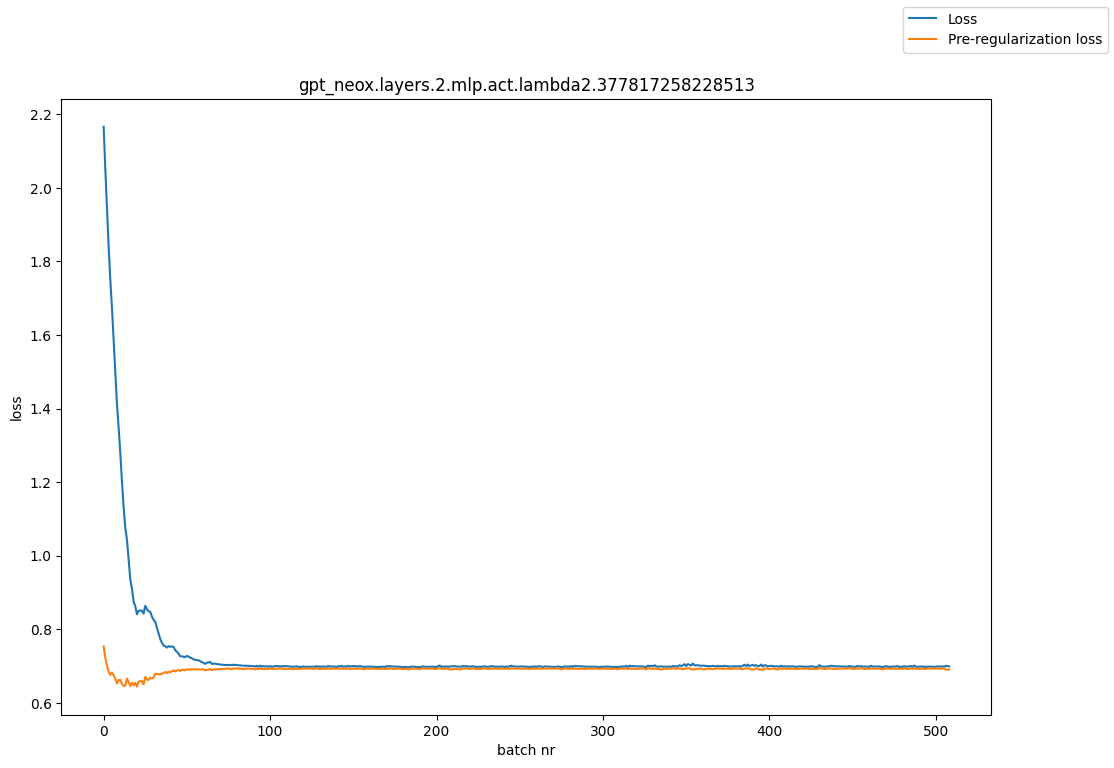

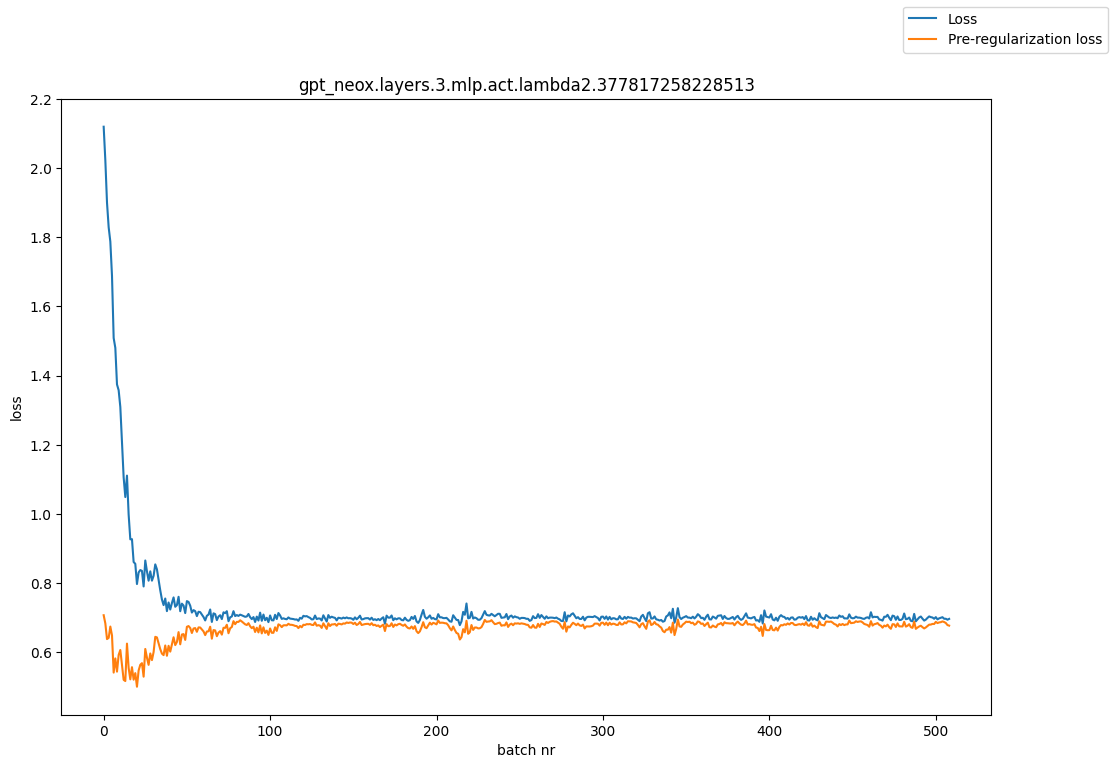

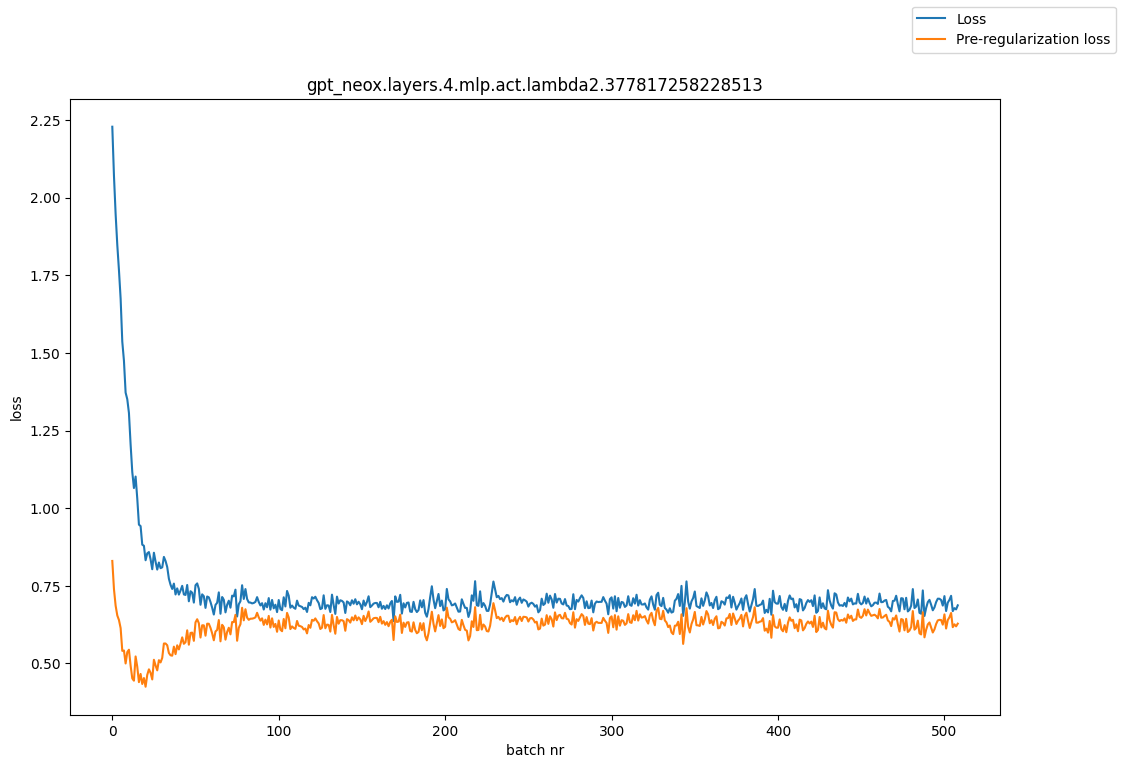

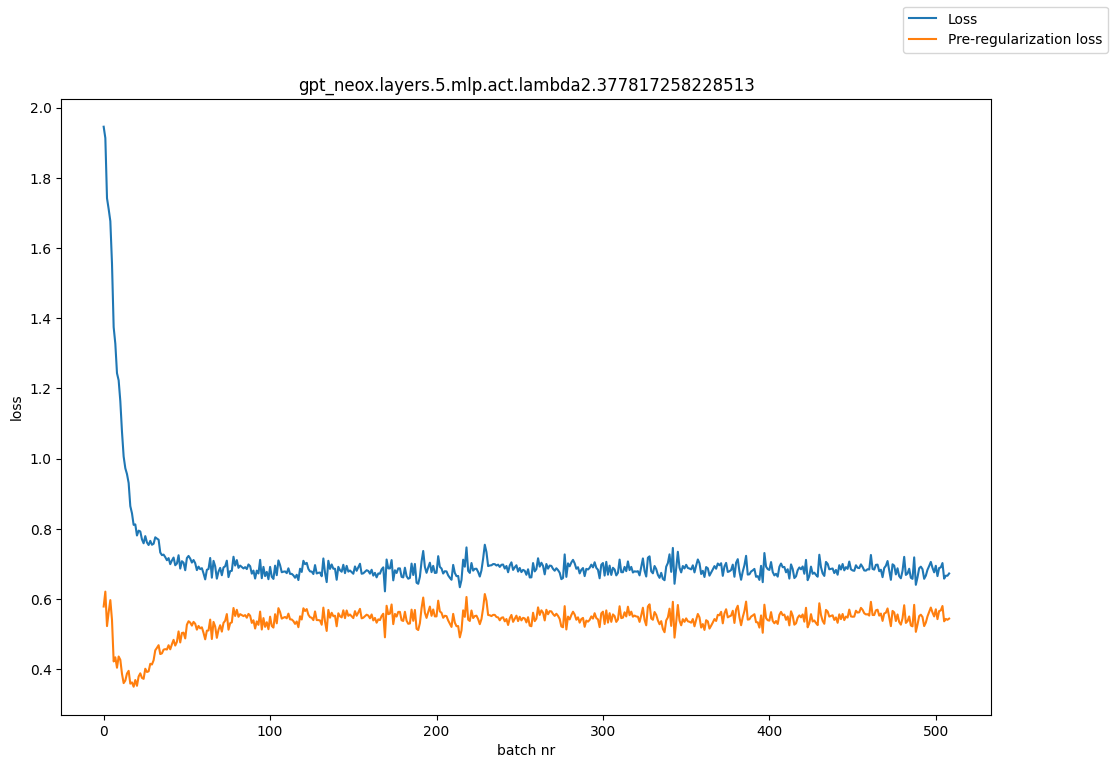

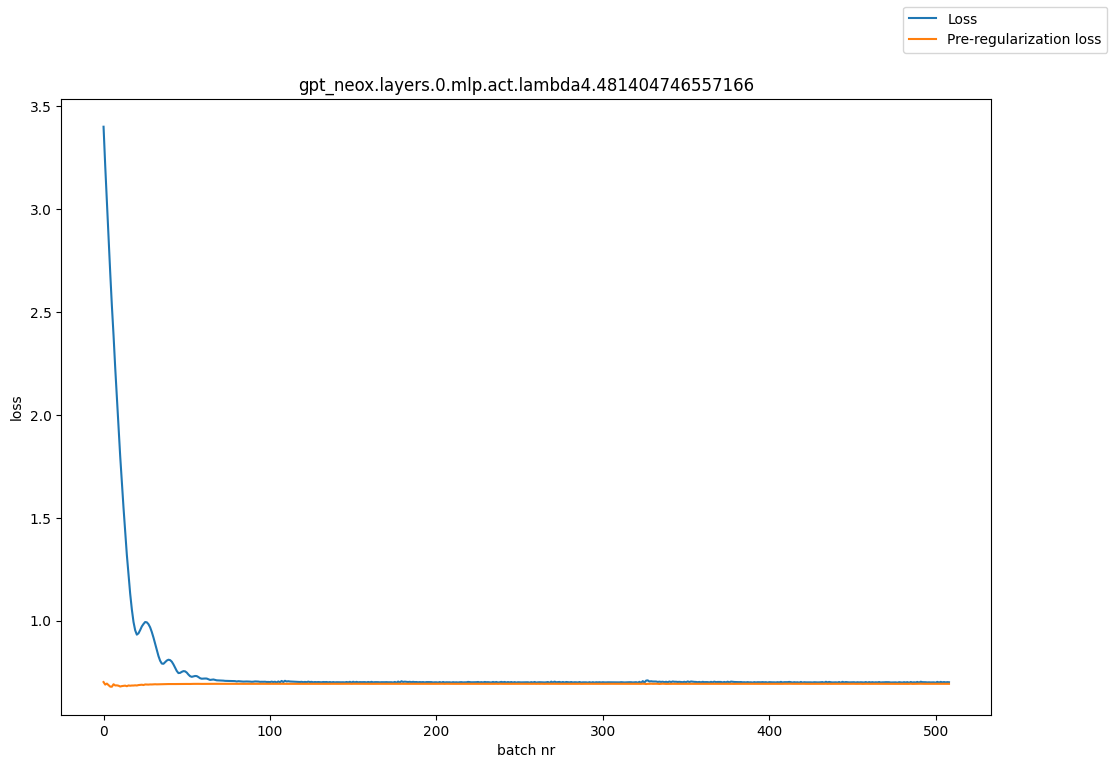

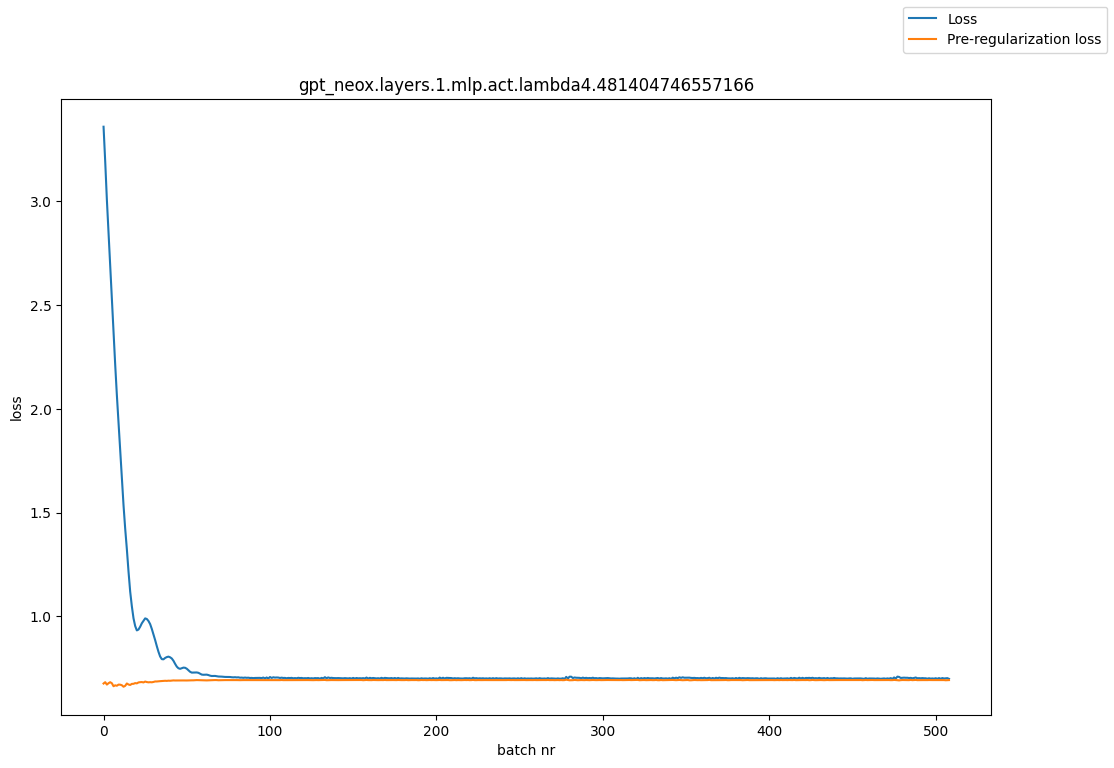

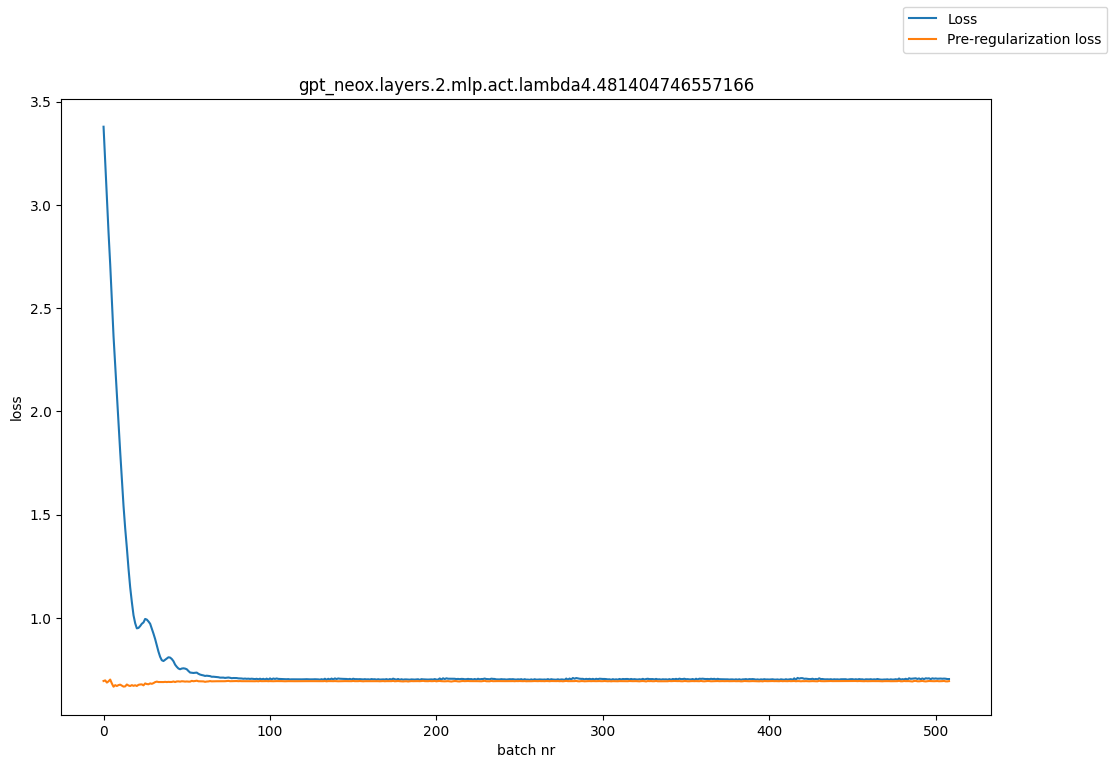

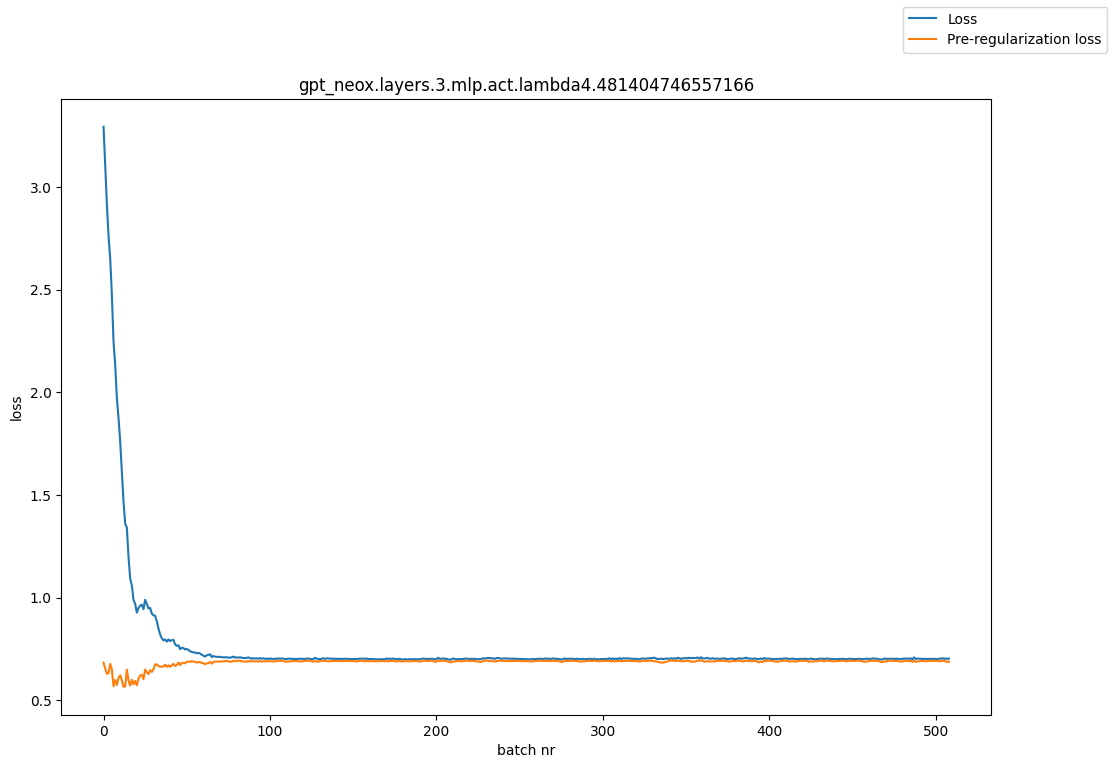

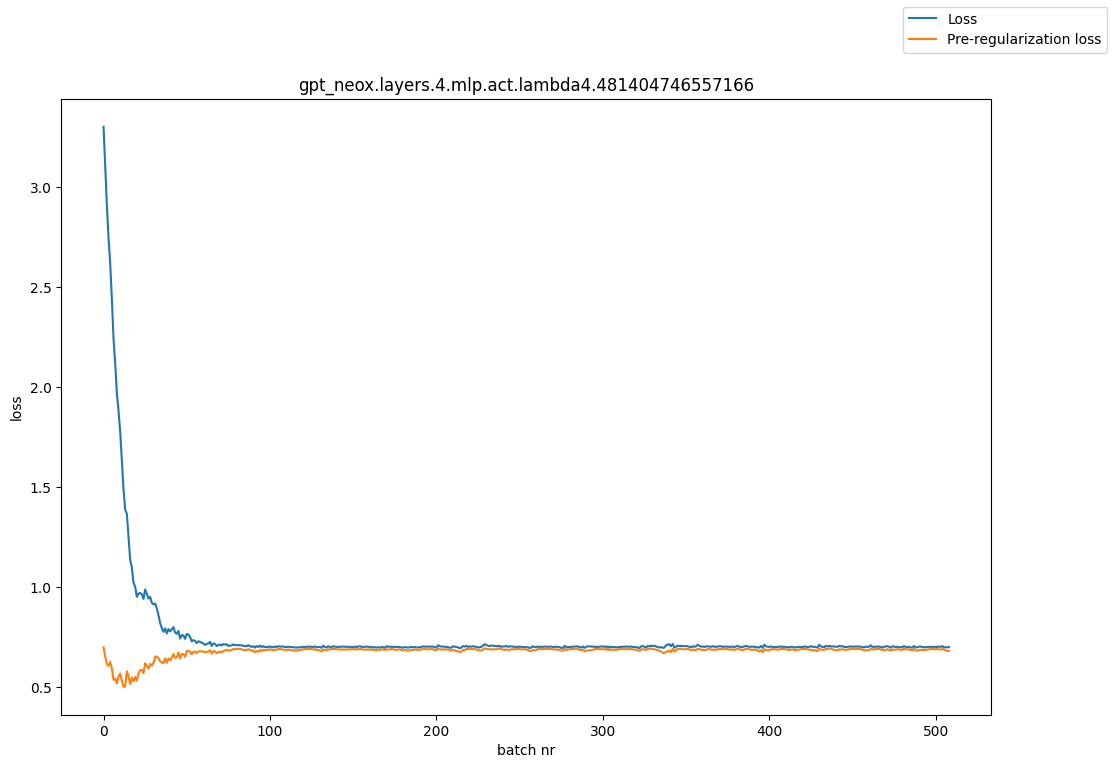

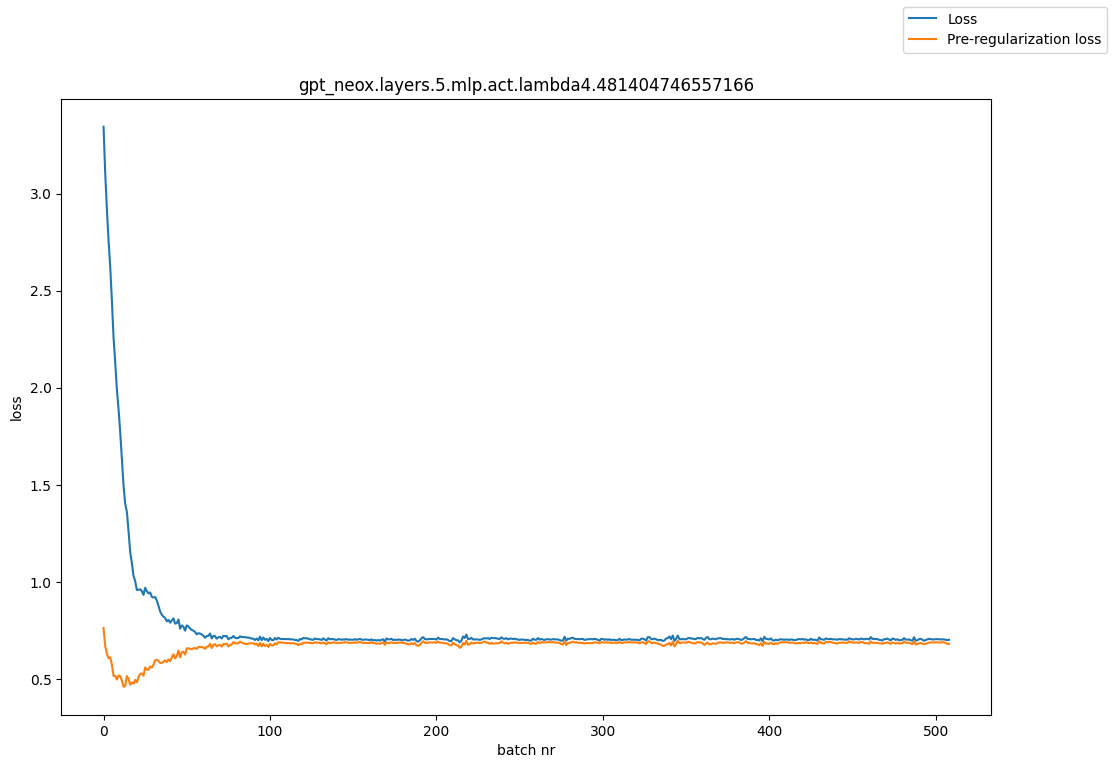

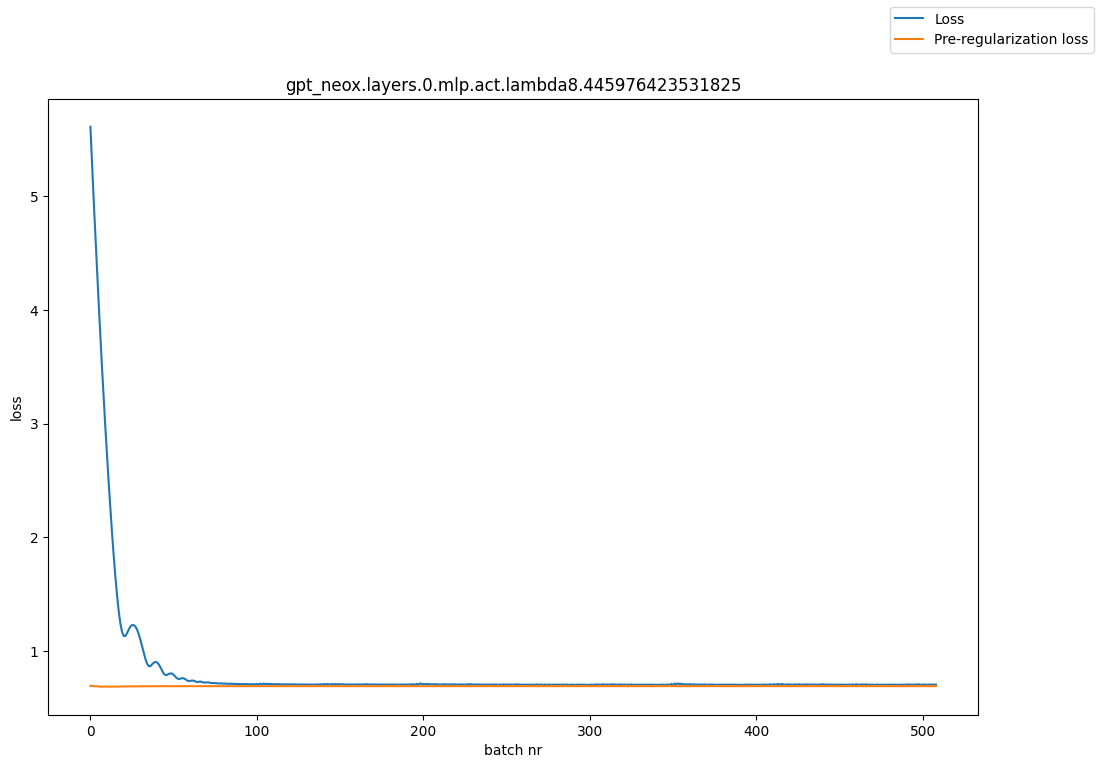

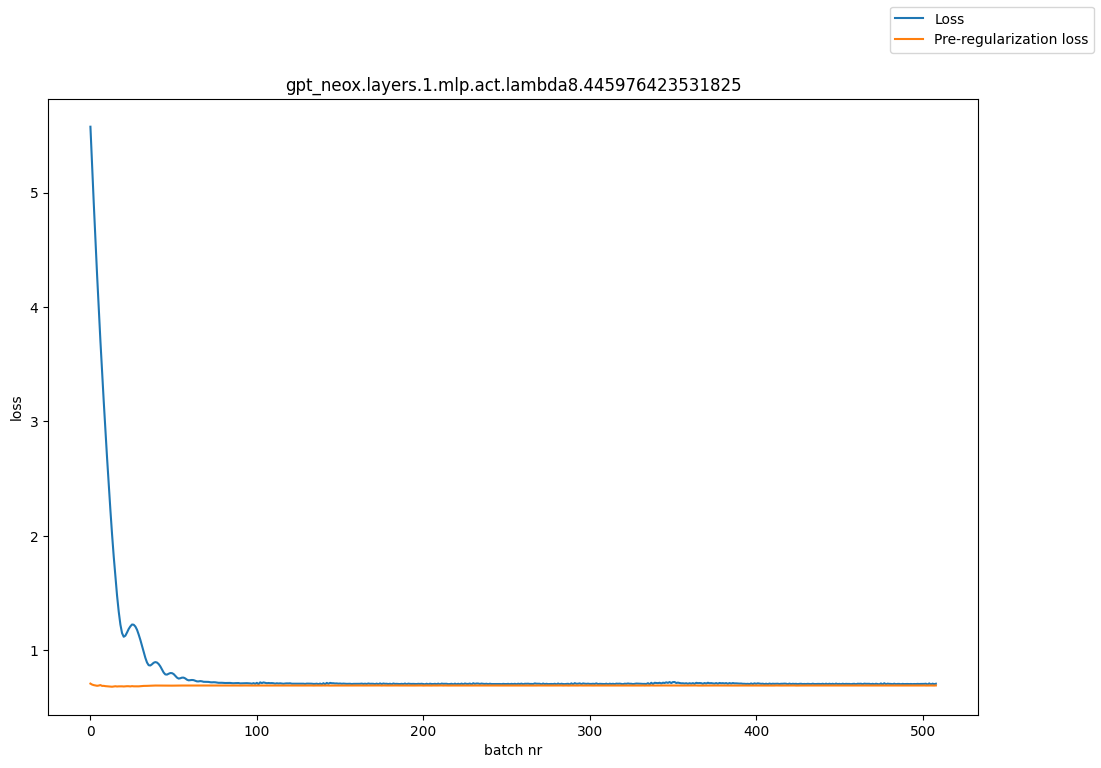

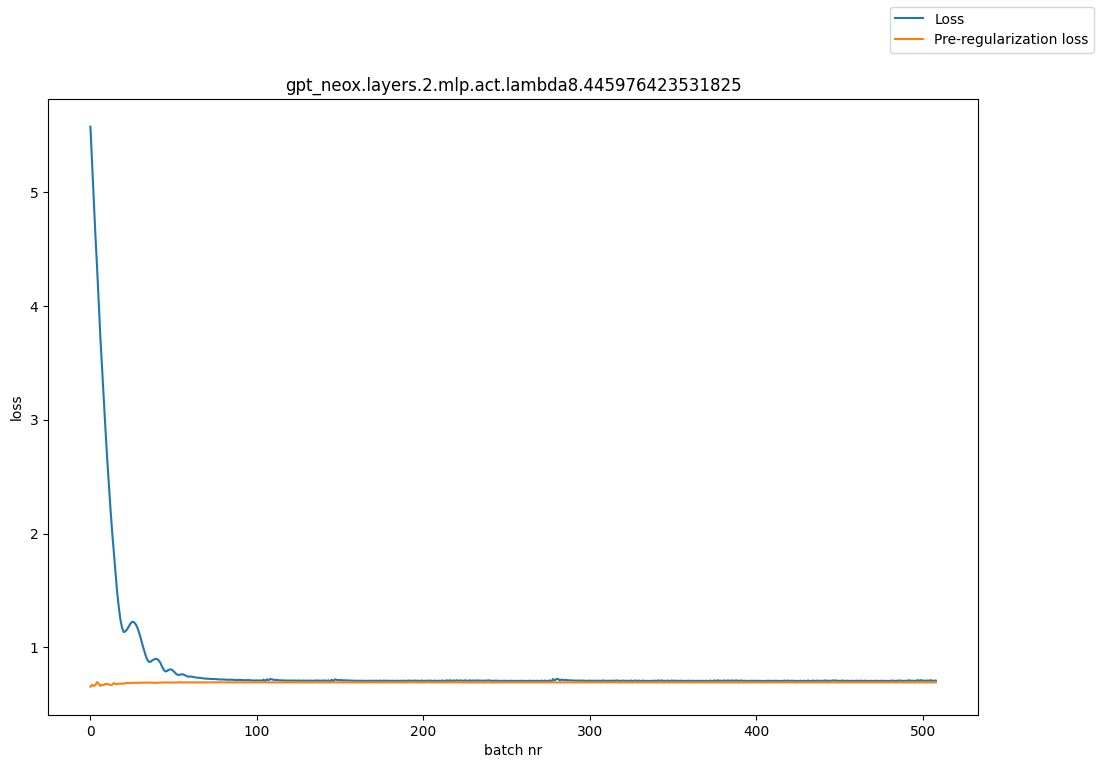

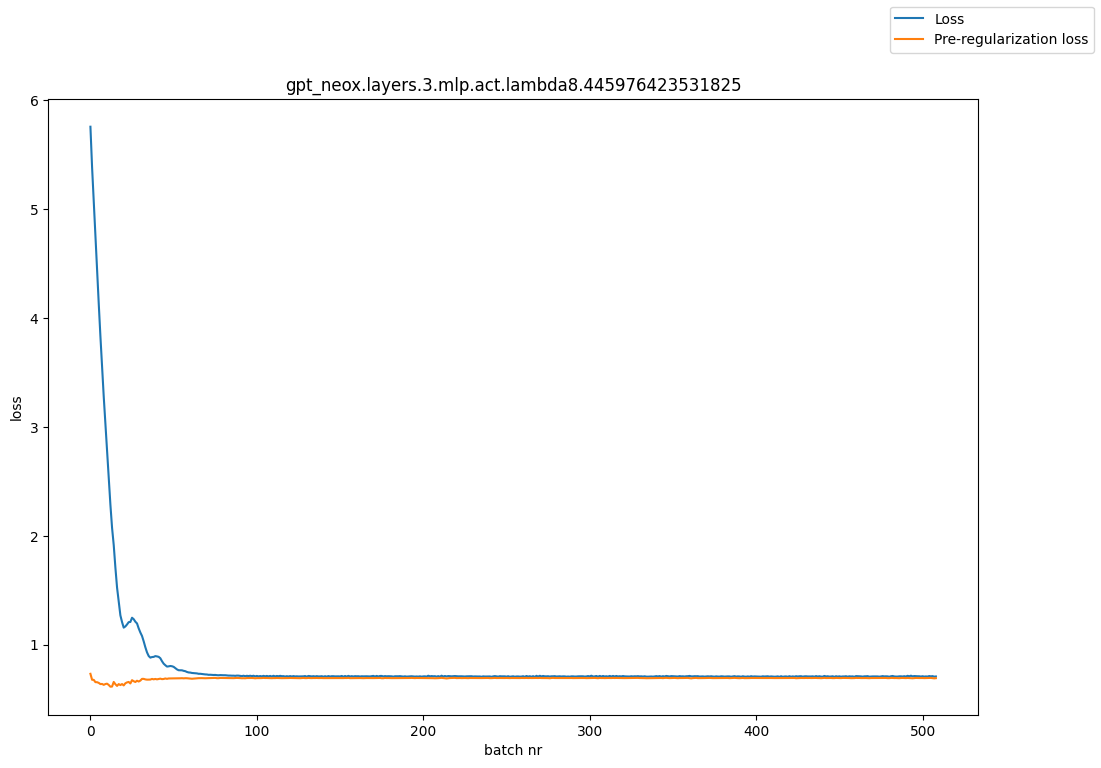

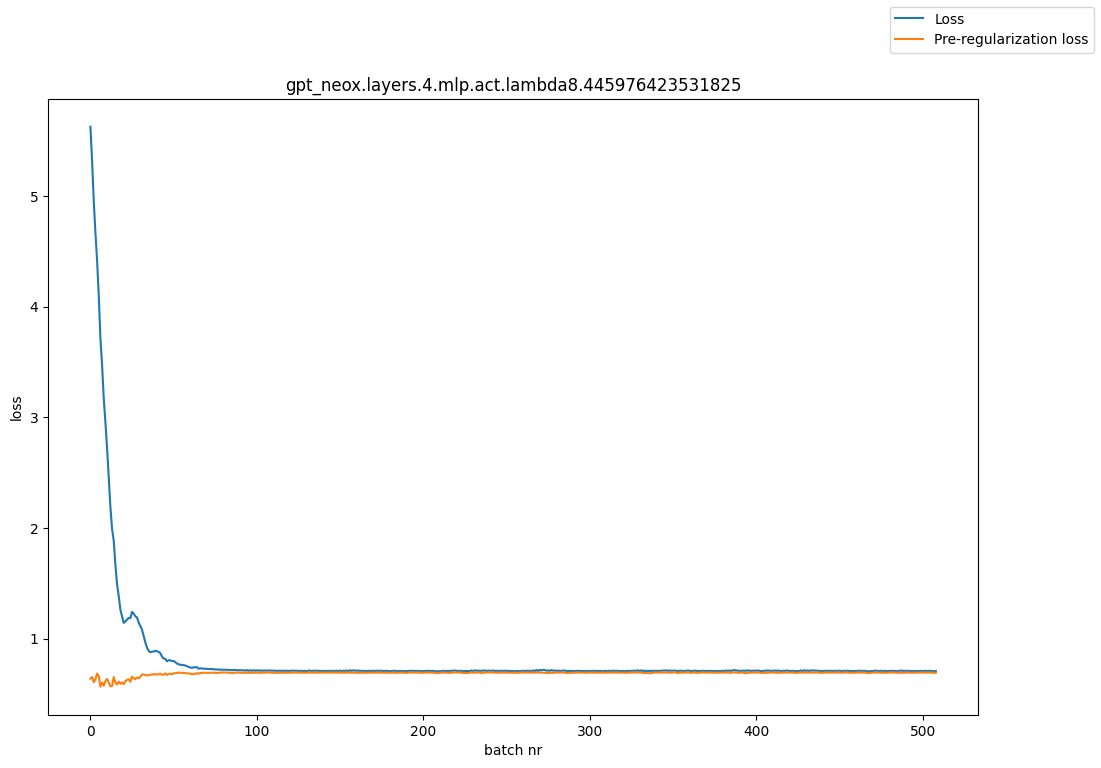

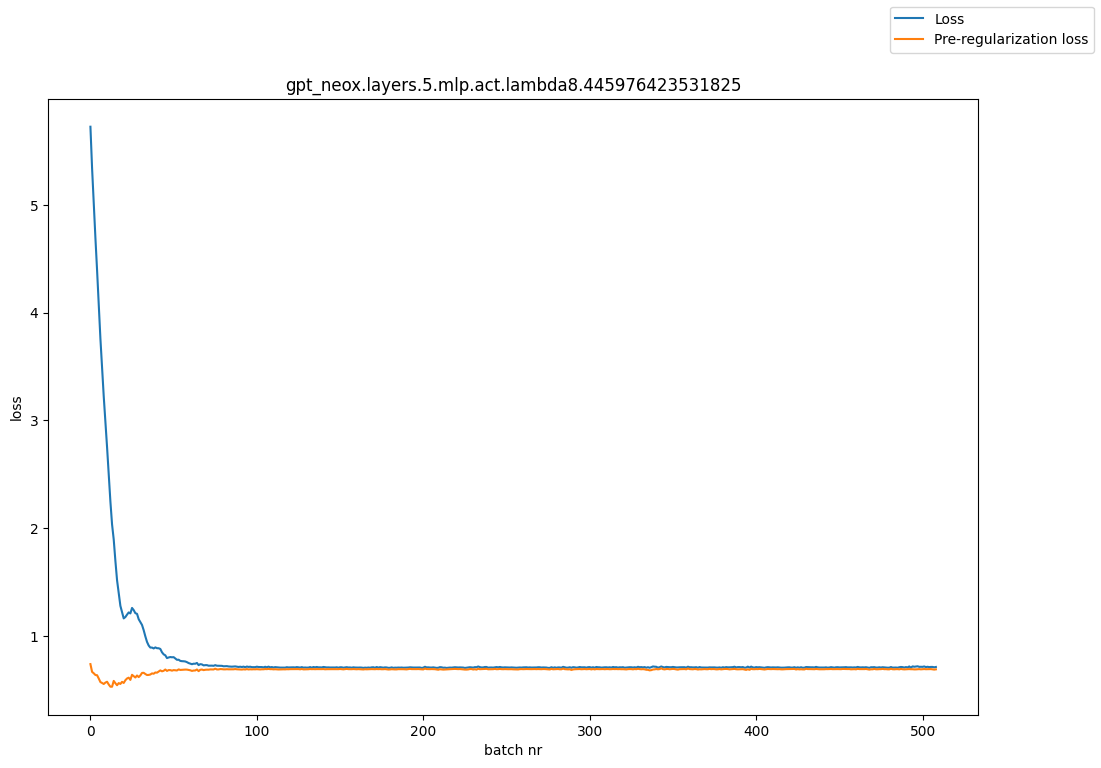

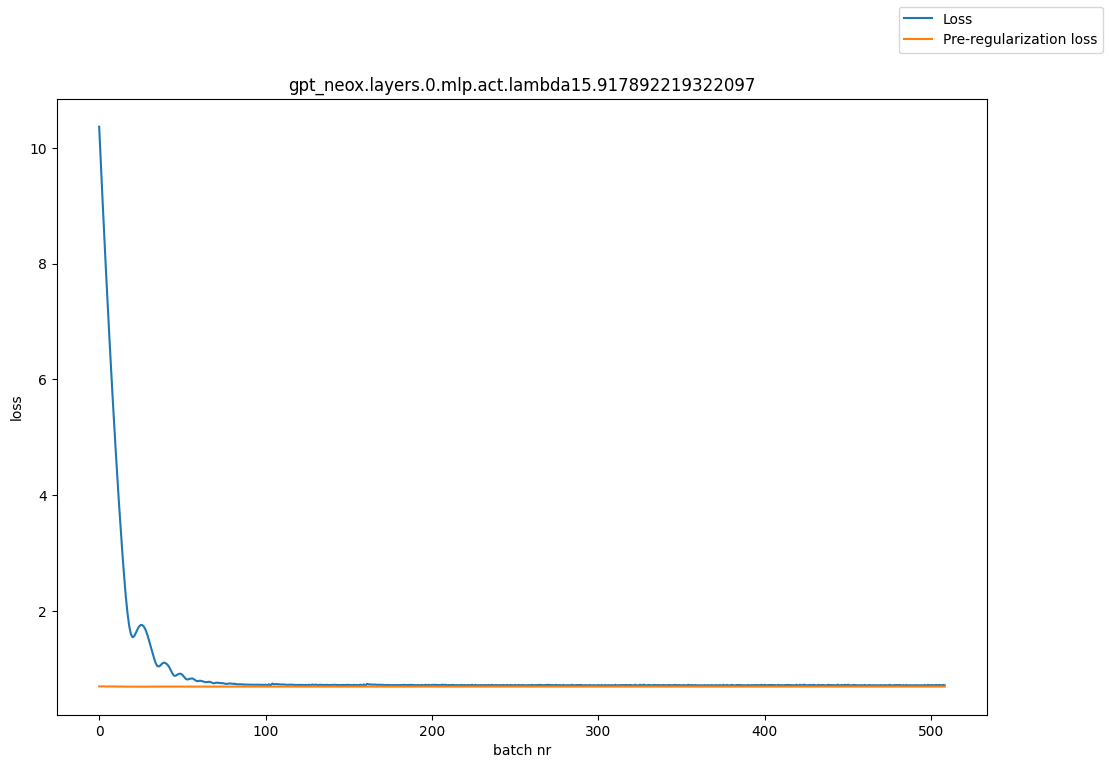

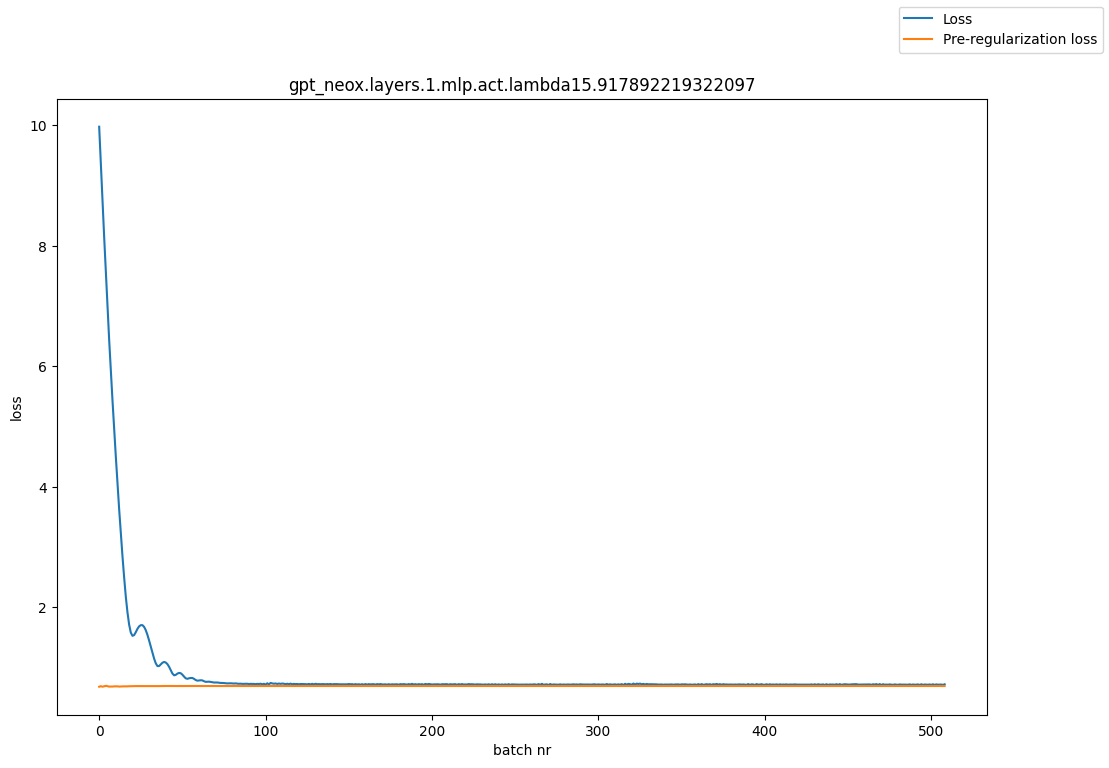

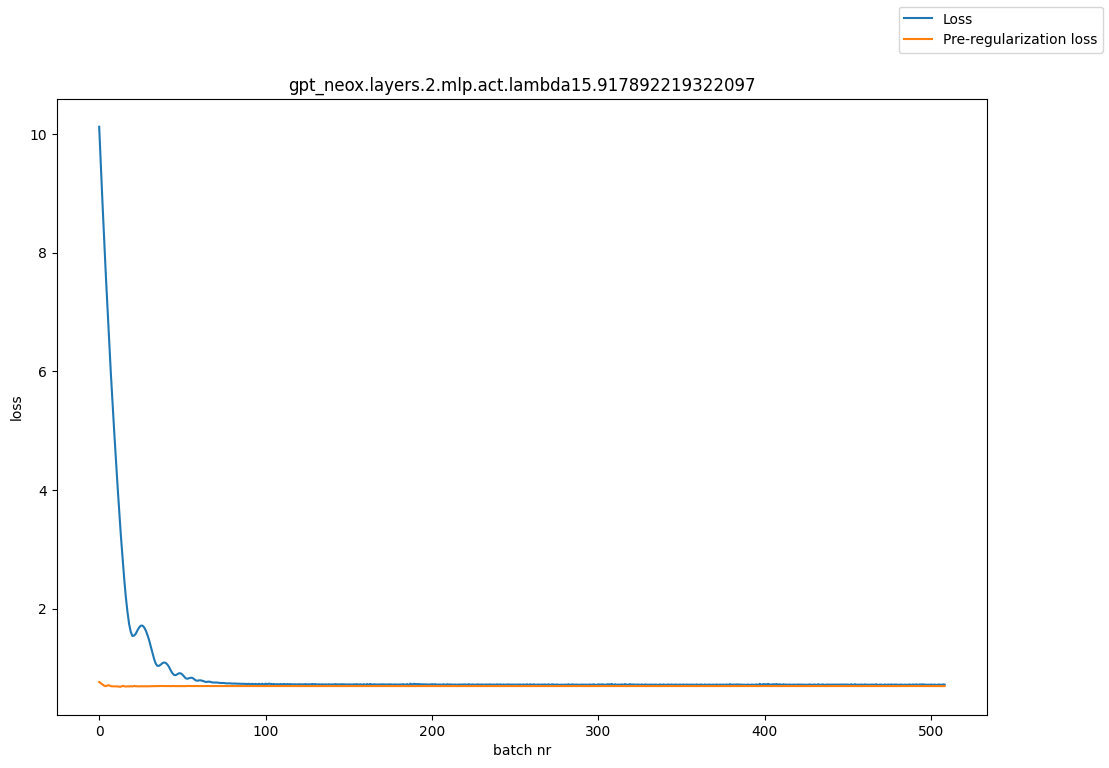

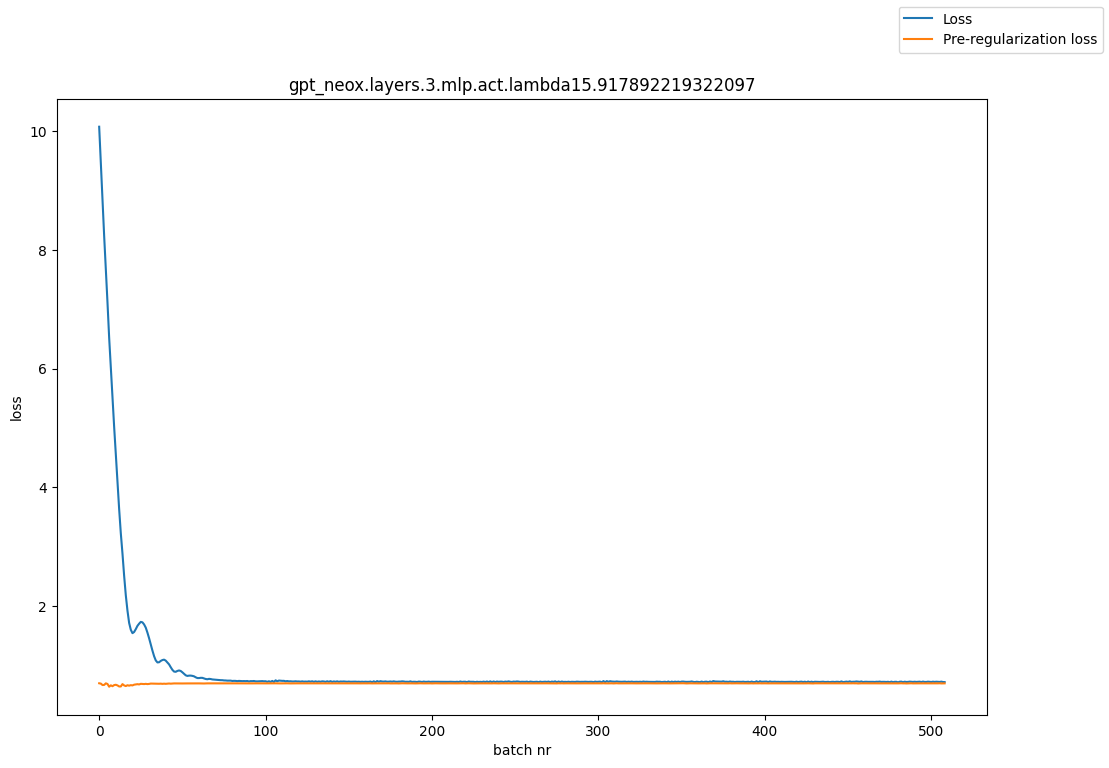

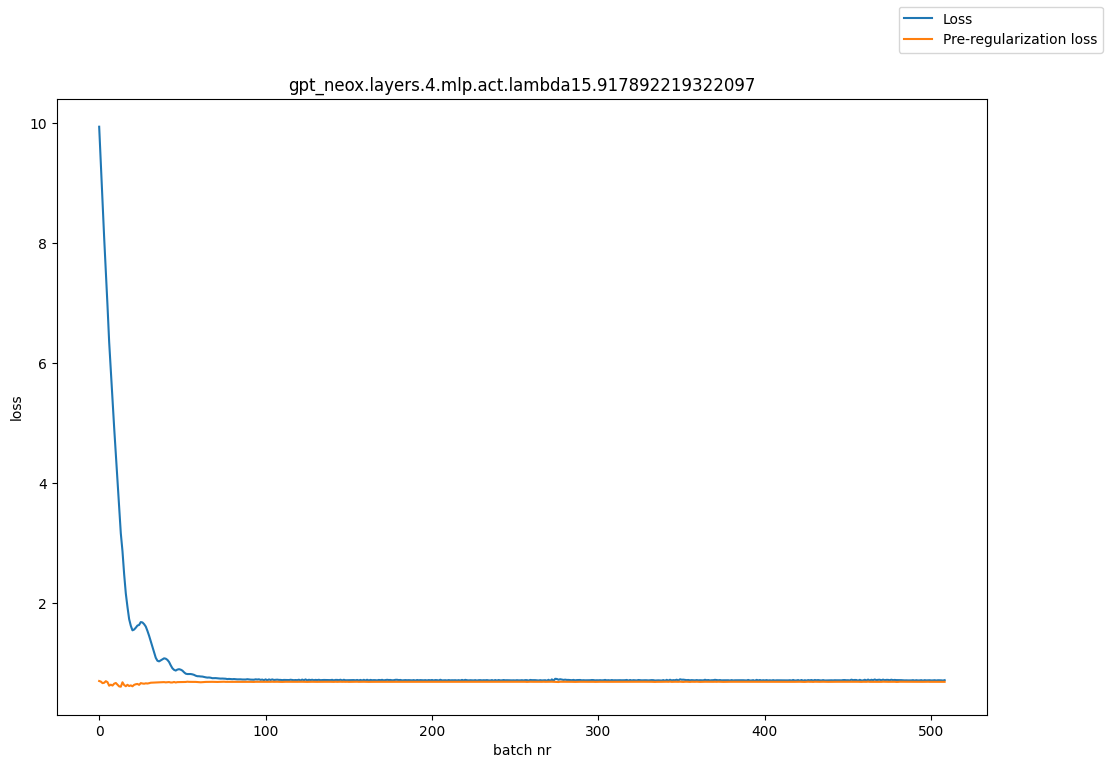

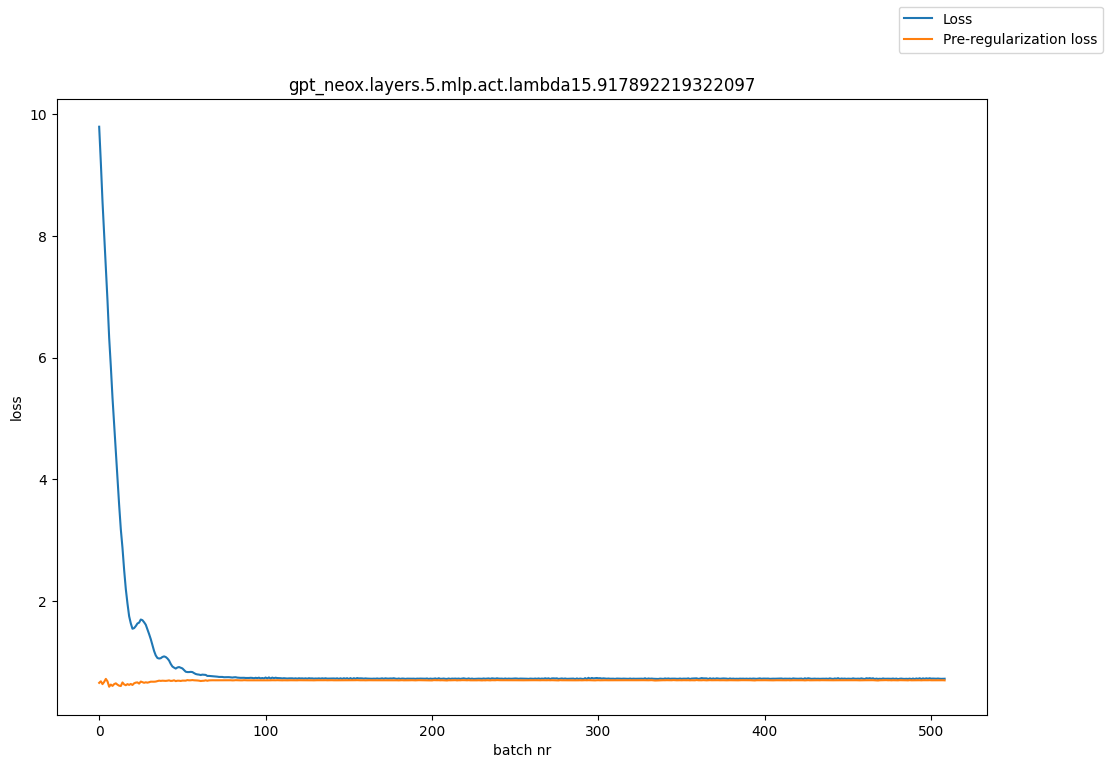

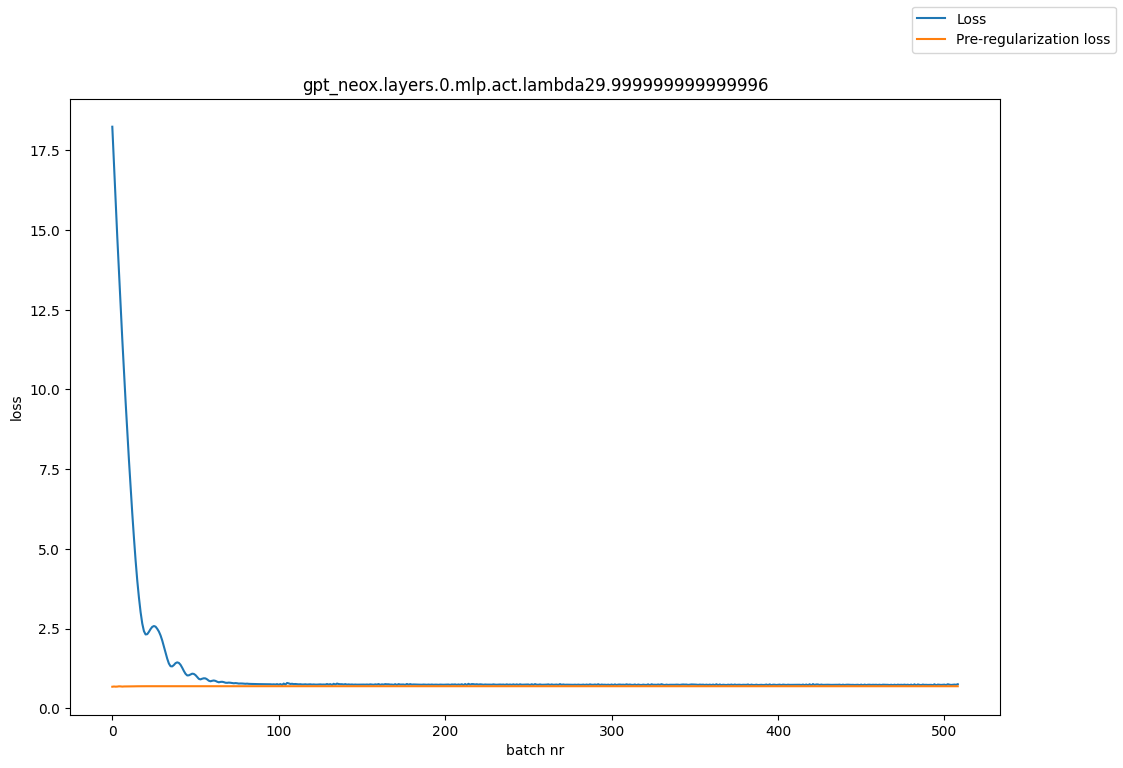

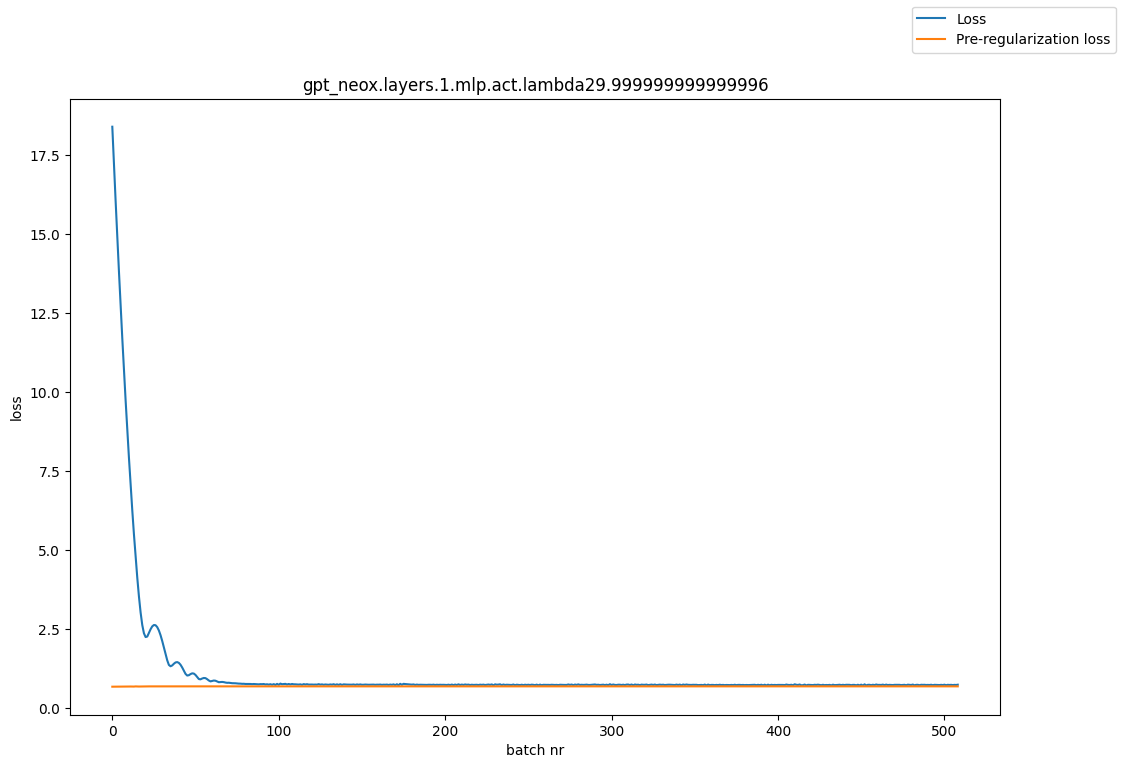

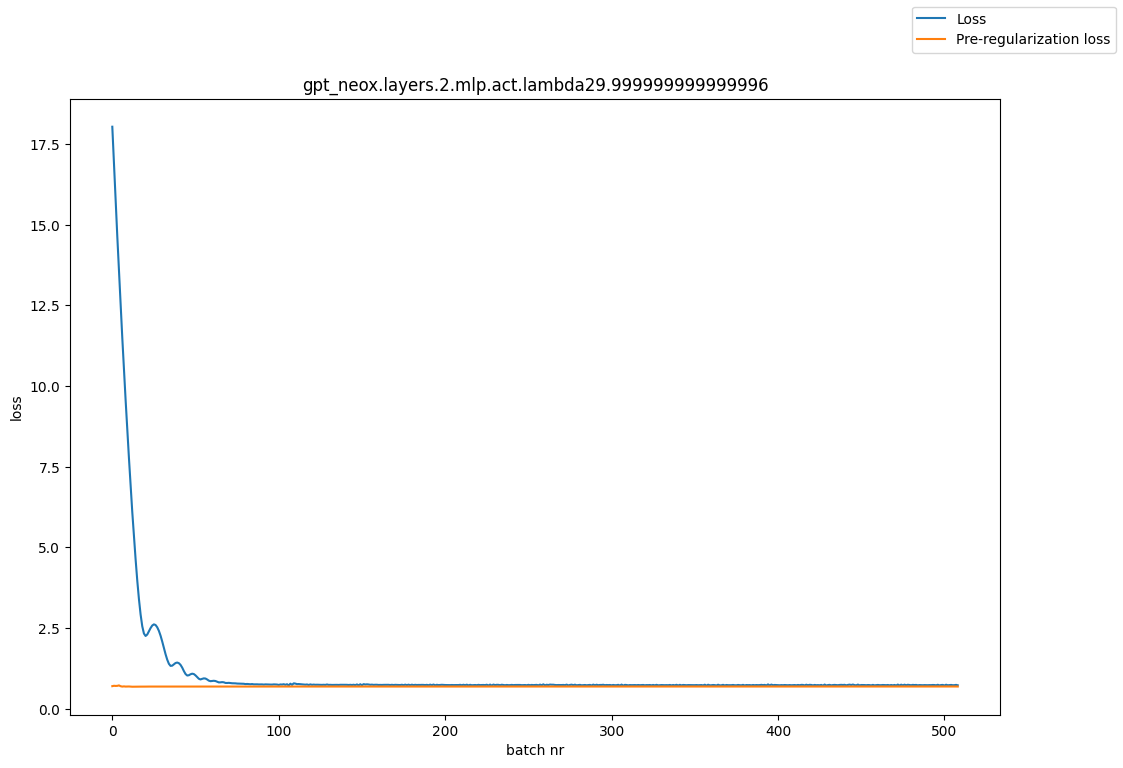

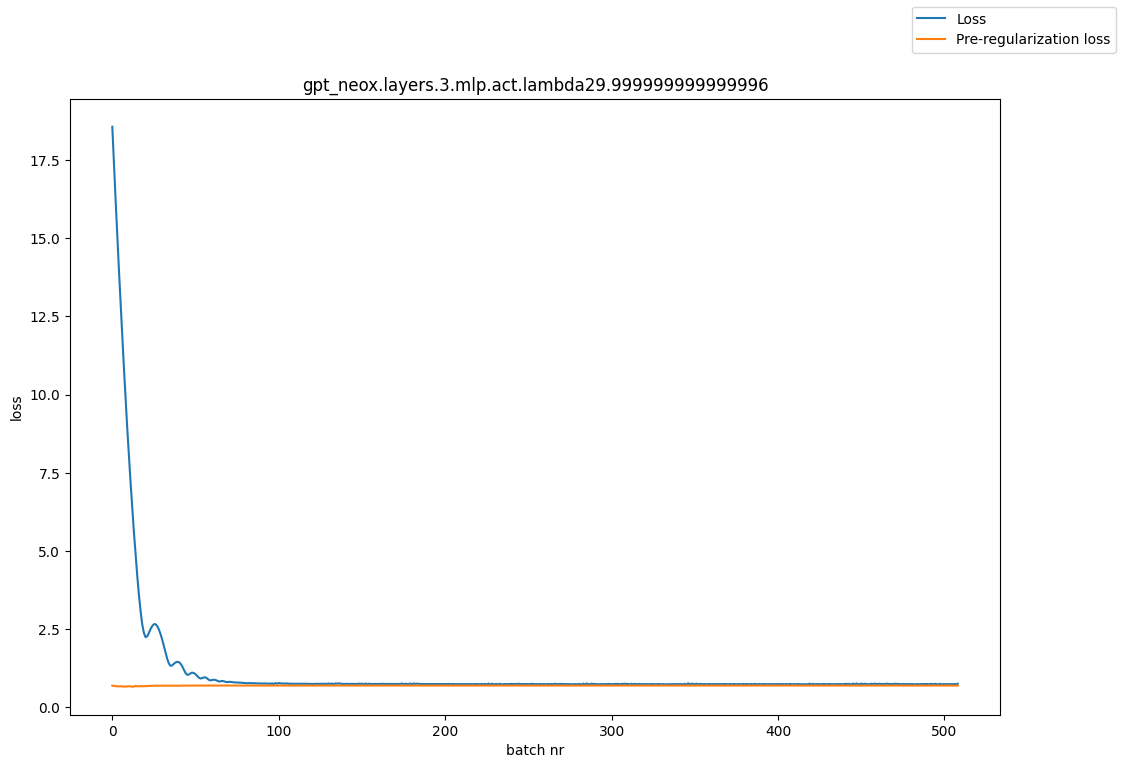

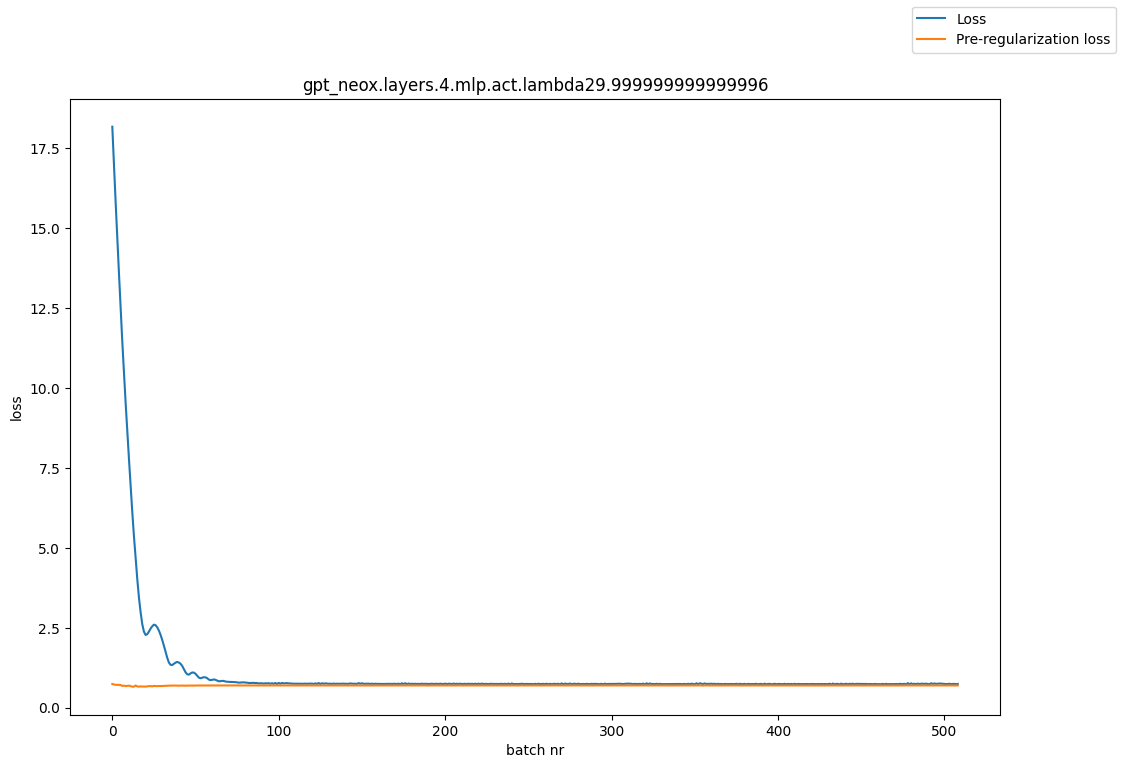

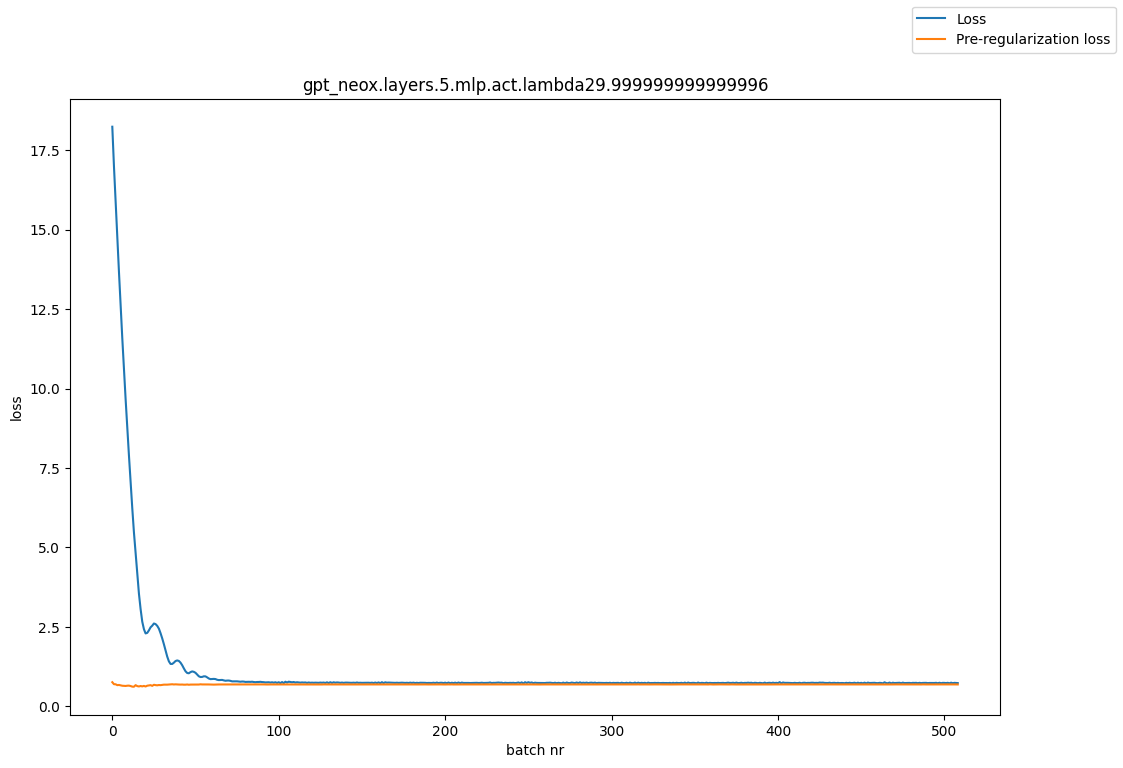

In [6]:
out_folder = f"models/sparse_probes/{model_url.split('/')[-1]}"
log_folder = f"training_logs/sparse_probes/{model_url.split('/')[-1]}"


if not os.path.isdir(out_folder):
    os.mkdir(out_folder)
if not os.path.isdir(log_folder):
    os.mkdir(log_folder)

for probe_trainer in probe_trainers:

    out_folder_reg_lambda = out_folder + f'/reg_lambda{probe_trainer.reg_lambda}'
    log_folder_reg_lambda = log_folder + f'/reg_lambda{probe_trainer.reg_lambda}'

    if not os.path.isdir(out_folder_reg_lambda):
        os.mkdir(out_folder_reg_lambda)
    if not os.path.isdir(log_folder_reg_lambda):
        os.mkdir(log_folder_reg_lambda)

    probe = probe_trainer.model
    hookpoint = probe_trainer.hookpoint

    model_out_path = out_folder_reg_lambda + f'/{hookpoint}.pt'
    meta_data_out_path = out_folder_reg_lambda + f'/{hookpoint}.json'
    log_path = log_folder_reg_lambda + f'/{hookpoint}.csv'
    log_fig_path = log_folder_reg_lambda + f'/{hookpoint}.png'

    torch.save(probe.state_dict(), model_out_path)

    meta_data = {
        'batch_size': batch_size,
        'num_batches_trained_on': probe_trainer.batches,
        'learning_rate': probe_trainer.learning_rate,
        'input_size': probe_trainer.input_size,
        'reg_lambda': probe_trainer.reg_lambda,
        'hookpoint': probe_trainer.hookpoint
    }

    with open(meta_data_out_path, 'w') as file:
        json.dump(meta_data, file, indent=4)

    losses, pre_reg_losses = zip(*probe_trainer.losses)
    df = pd.DataFrame({'loss': losses, 'pre_reg_loss': pre_reg_losses})
    df.to_csv(log_path)

    probe_trainer.plot_loss(out_file=log_fig_path)

In [22]:
# insert github auth below --- couldnt figure out how to do it a better way
# REMEMBER TO DELETE AFTERWARDS!!!!!

## -----v------

## -----^------

In [13]:
!git config --global user.email "mk@sibbesen.dk"
!git config --global user.name "Markus Sibbesen"

In [14]:
!git add {out_folder}/*
!git add {log_folder}/*

!git commit -m "trained 70m probe"

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [23]:
!git push

Enumerating objects: 272, done.
Counting objects: 100% (272/272), done.
Delta compression using up to 2 threads
Compressing objects: 100% (268/268), done.
Writing objects: 100% (268/268), 14.10 MiB | 12.88 MiB/s, done.
Total 268 (delta 59), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (59/59), completed with 1 local object.
To https://github.com/MarkusSibbesen/mechinterp_research_project.git
   e954209..66c3eeb  main -> main
